# Tutorial: Simulating Mode-Locked Lasers using MLLMOD  
## Ref: RGB - "Fundamentals of Laser Modeling, Simulation, and Design"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import laser.mllmod as ml

In [2]:
# If you'd like to save pictures, then change this
# path to a folder on your local drive. Then include
# dirpath=dirpath in any of the calls to the
# ModeLockedLaserModel integrate method below.
dirpath = 'C:/Research/Projects/Laser Physics/figures/'

In [3]:
# Note that you can find info about class interfaces
# using python's help():
help(ml.LaserResonatorParameters)

Help on class LaserResonatorParameters in module laser.mllmod:

class LaserResonatorParameters(builtins.object)
 |  LaserResonatorParameters(r_1, r_2, loss_db=0.0)
 |  
 |  Collect parameters describing a passive laser resonator    
 |     Class used to store a set of parameters required to represent a passive laser cavity.
 |  
 |  Public Attributes
 |  -----------------
 |  r_1 : numpy.float64
 |      Intensity reflectance of the output coupling mirror (0 < r_1 < 1)
 |  r_2 : numpy.float64
 |      Intensity reflectance of the back mirror (0 < r_2 <= 1)
 |  tau_pho : numpy.float64
 |      The group round-trip propgation time of the laser cavity
 |      
 |  Public Methods
 |  --------------
 |  get_keywords : string
 |      String containing the attributes of a
 |      LaserResonatorParameters object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, r_1, r_2, loss_db=0.0)
 |      Initialize a LaserResonatorParameters object.
 |      
 |      Parameters
 |      ----------
 |      

# Diode Laser
### Let's start with a simple laser that has a long gain recovery time

## Parameters

In [4]:
r_1 = 0.1                    # Intensity reflectance of the output coupling mirror
r_2 = 1.0                    # Intensity reflectance of the back-reflecting mirror (output not computed)
loss_db = 1.0                # Total round-trip background and scattering loss in dB

tau_grp = 75.0               # Group round-trip time in ps
tau_prp = 0.3 / tau_grp      # Transverse relaxation time in units of tau_grp
disp = []                    # (Empty) list of dispersion coefficients

tau_par = 1500.0 / tau_grp   # Gain recovery lifetime in units of tau_grp
gbar_0 = 1.05                # Pump in units of the threshold gain

q_max = 10                   # Mode indices run from -q_max to q_max (2 * q_max + 1 total modes)

# First, create a container for the parameters that describe
# the "bare" laser resonator
params_res = ml.LaserResonatorParameters(r_1, r_2, loss_db)

# Second, compute the gain and create a containing for the material parameters
params_mat = ml.LaserMaterialParametersFLL(tau_par, gbar_0)

# Third, create an object with functions that support calculations
# of frequency shifts and time delays.
freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)

## Unidirectional Ring Laser : Single-Mode

ModeLockedLaserModel

LaserResonatorParameters
R_1 = 0.1; R_2 = 1.0; loss_db = 1.0 dB; tau_pho/tau_grp = 0.395

FrequencyShifts
q = [-10, 10]; tau_prp/tau_grp = 0.004; tau_prp/tau_pho = 0.0101; alpha = 0.0

ActiveLaserMediumAWM
LaserConfigurationURL
LaserMaterialParametersFLL
tau_par/tau_grp = 20.0; Gbar_0 = 1.05; alpha = 0.0; I_sat = 1.0



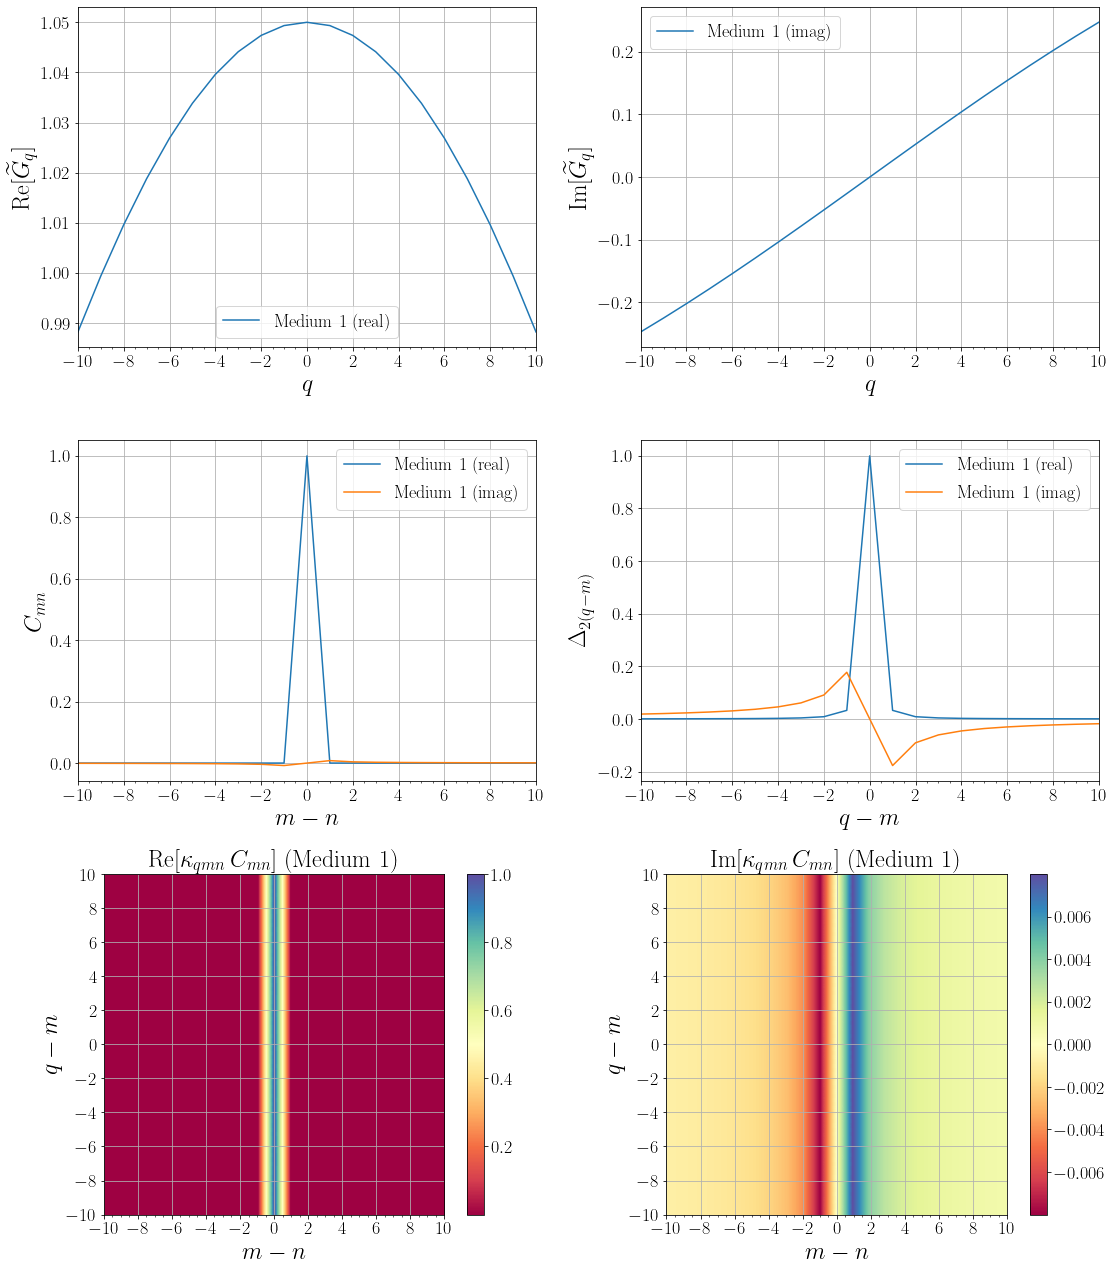

Elapsed time: 10 seconds (DOP853)
Derivative function calls: 22742 (2.27e+03 calls/sec)


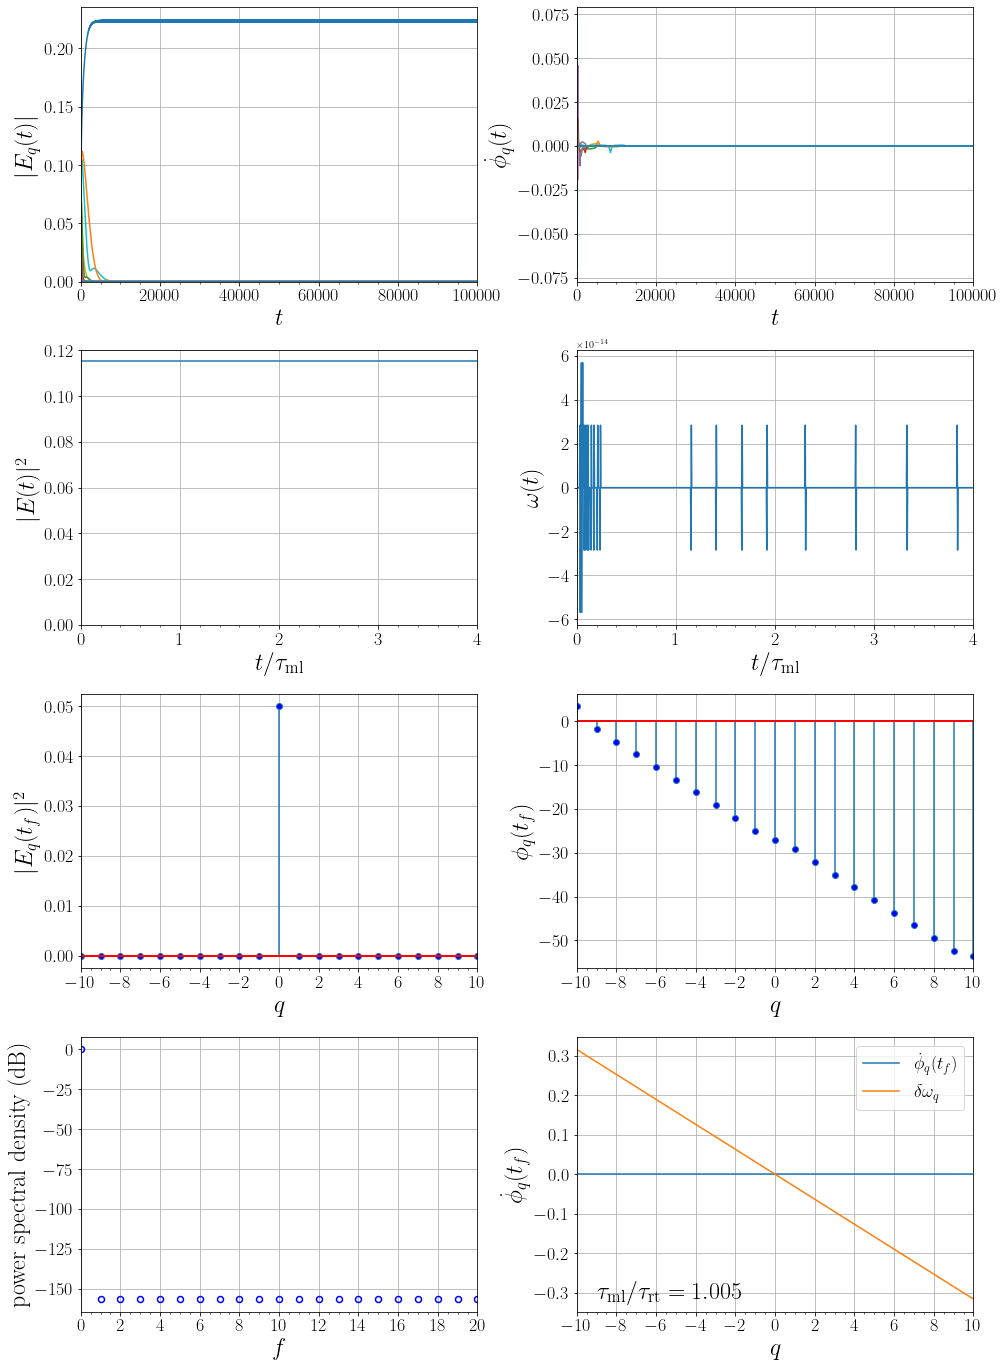

In [5]:
# Choose the spatial configuration of the amplifier (URL, SWL, or SHB),
# and then create the object that represents the amplifier. The amplifier
# can choose to compute the polarization based on either FWM or AWM.
config_res = ml.LaserConfigurationURL(params_res)
amplifier = ml.ActiveLaserMediumAWM(params_mat, config_res, freq_shifts)

# We're ready to build the model. We can print all of the parameters used
# by the entire model, and then plot the net gain, the frequency coupling
# coefficients, and the spatial coupling coefficients.
model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
print(model)
model.modplot()

# Choose a final time (in units of the round-trip time),
# and then integrate the ODEs for each field component.
# The default algorithm we use for scipy.integrate.solve_ivp
# is DOP853. In this case, we see single-mode output.
t_max = 100000
model.integrate(t_max)

Elapsed time: 0.081 seconds (BDF)
Derivative function calls: 281 (3.47e+03 calls/sec)
Jacobian function calls: 9 (1.11e+02 calls/sec)


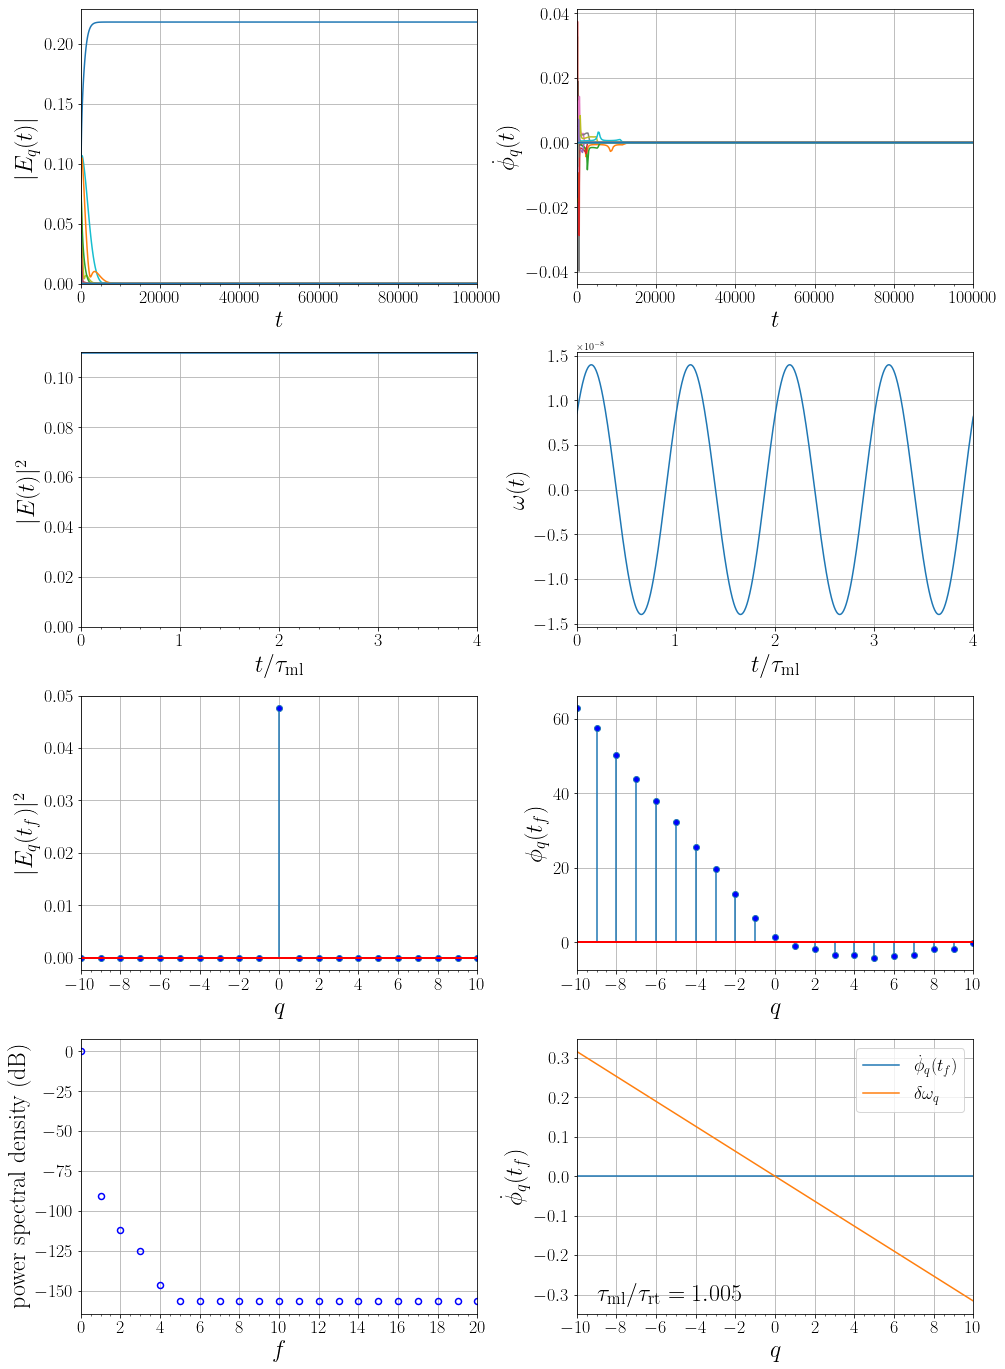

In [6]:
# We can also specify that the amplifier compute the polarization
# using FWM (four-wave mixing). In this case, because ActiveLaserMediumFWM
# enables the computation of the Jacobian of the derivative, we can use
# stiff integration methods (Radau, BDF, or LSODA). When simulating complex
# lasers, this approach is usually about two times faster than AWM, but in
# simple cases it can be much faster.
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)
model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
model.integrate(t_max, method='BDF')

## Standing-Wave Laser : Single-Mode

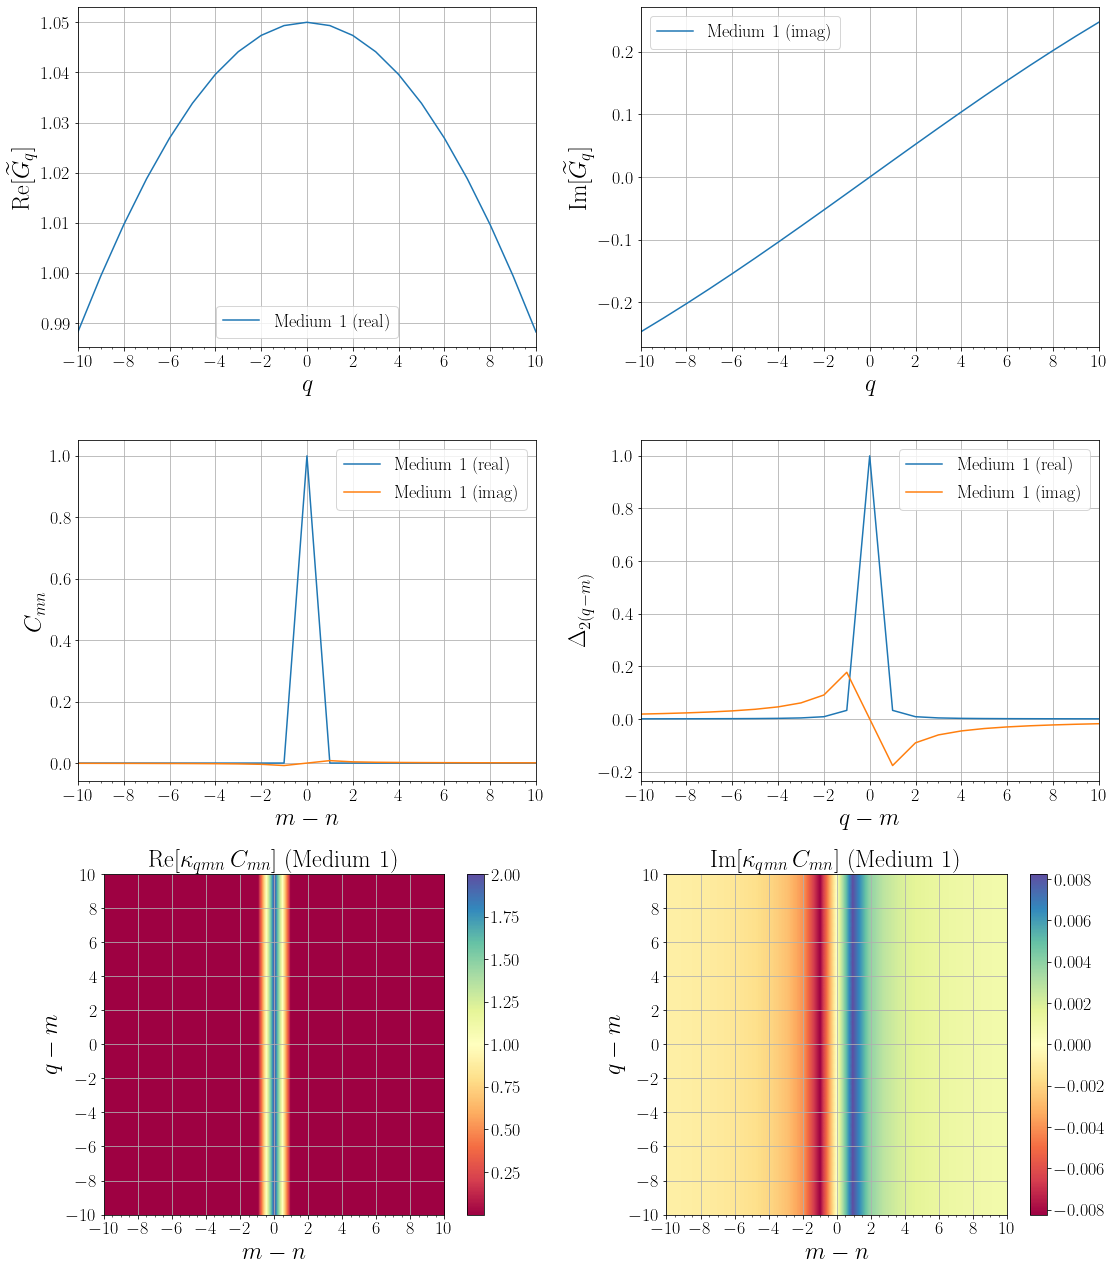

Elapsed time: 8 seconds (DOP853)
Derivative function calls: 22742 (2.84e+03 calls/sec)


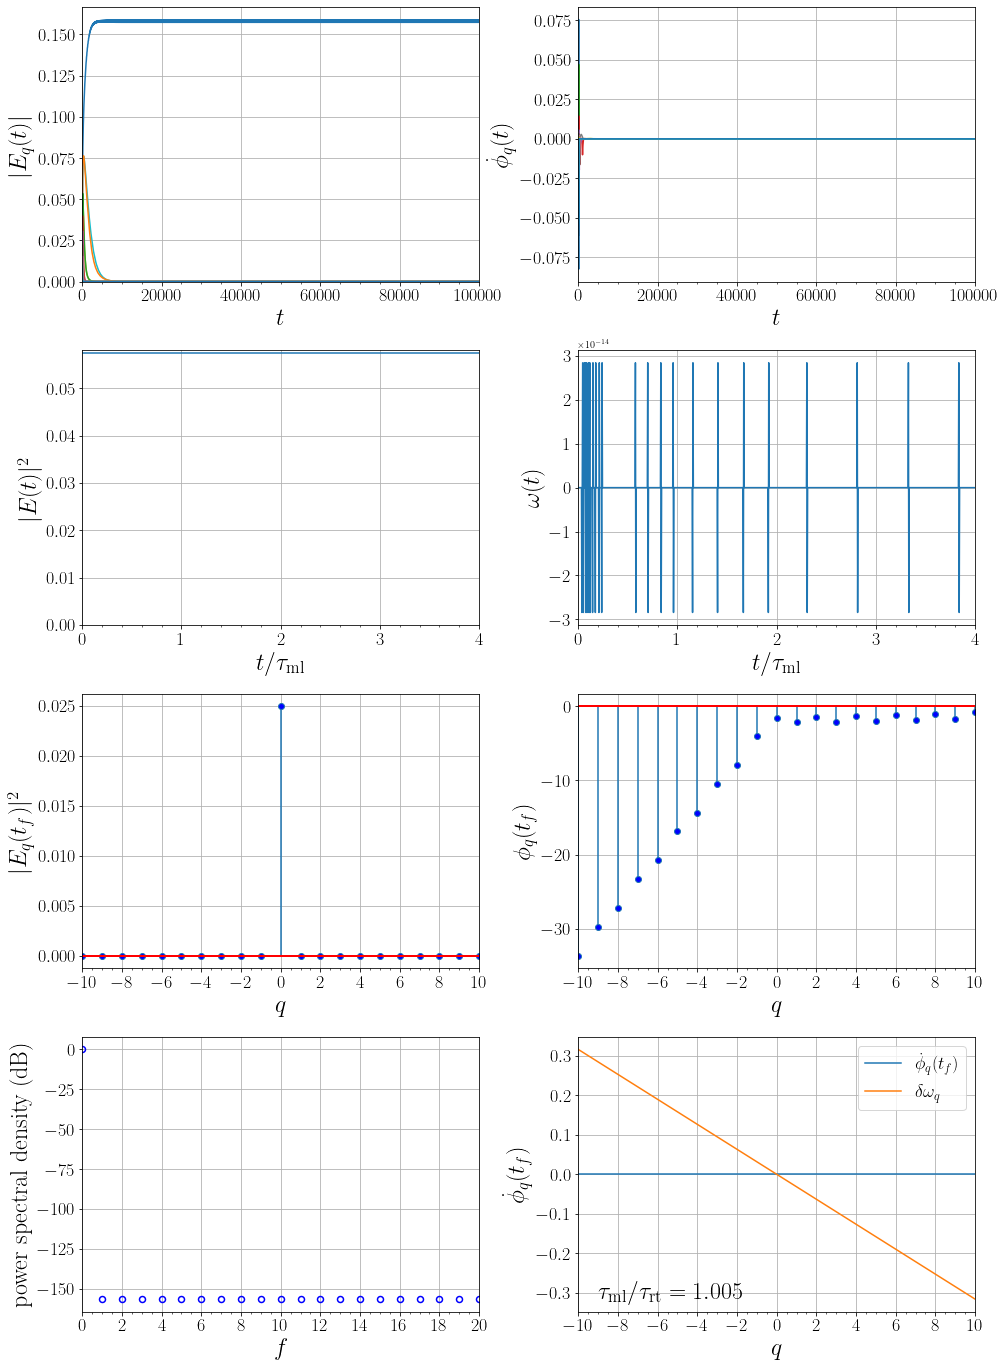

In [7]:
# Let's use AWM again, but use a SWL spatial configuration (which ignores
# SHB). We still see single-mode output.
config_res = ml.LaserConfigurationSWL(params_res)
amplifier = ml.ActiveLaserMediumAWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
model.modplot()
model.integrate(t_max)

## Spatial Hole-Burning : Chaotic(?)

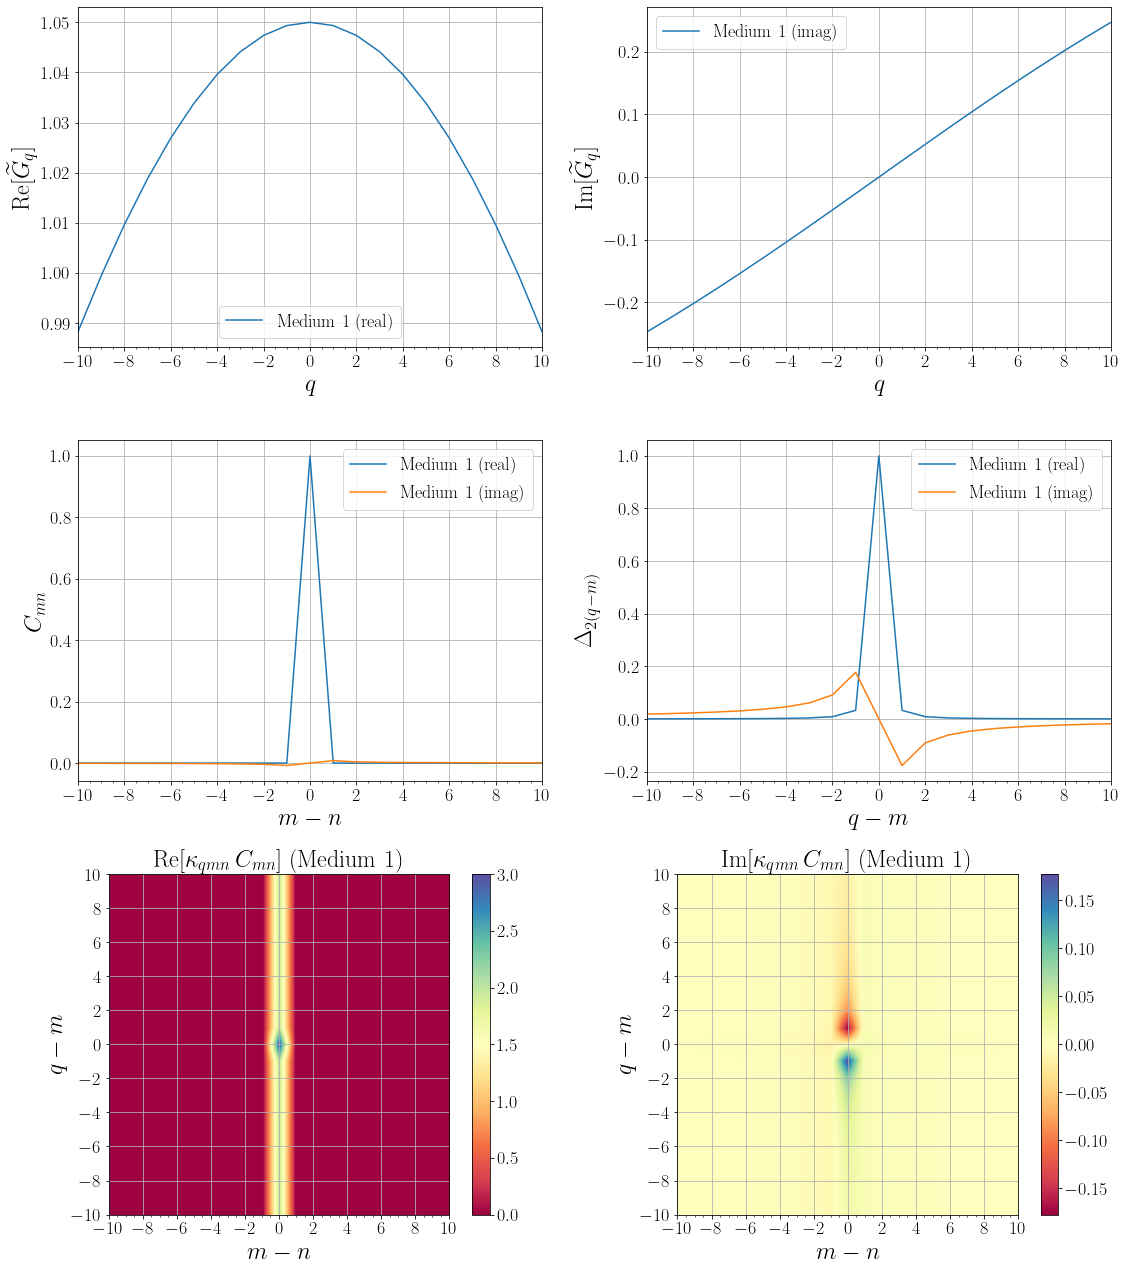

Elapsed time: 1 seconds (BDF)
Derivative function calls: 3492 (3.49e+03 calls/sec)
Jacobian function calls: 601 (6.01e+02 calls/sec)


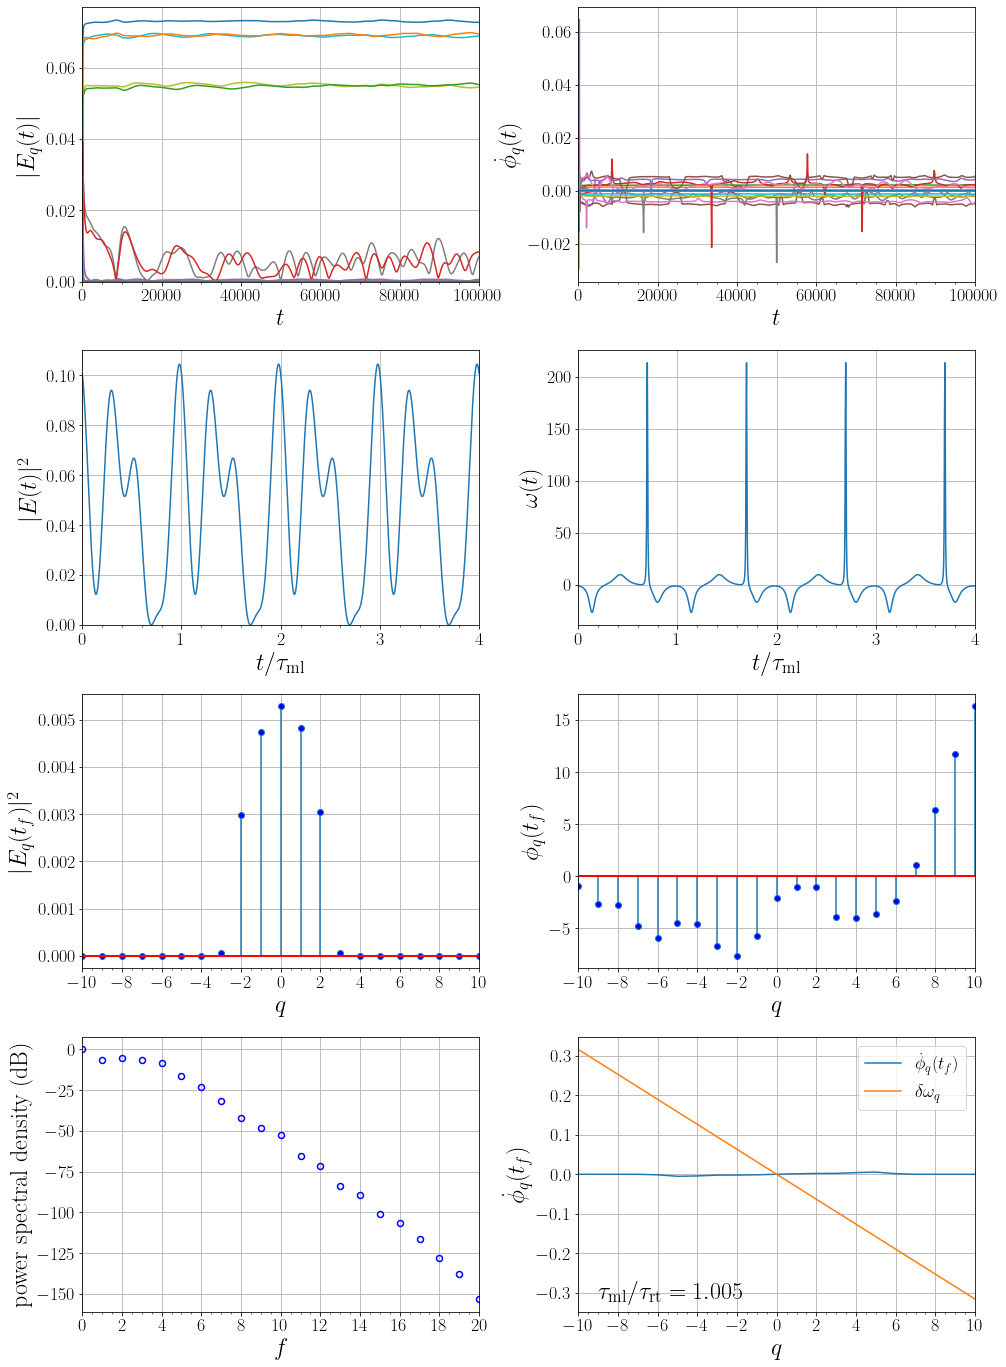

In [8]:
# Now let's include SHB with FWM. We see multi-mode behavior, but there's no
# fixed relationship between the phases of the modes. The result is chaotic,
# rather then mode-locked.
config_res = ml.LaserConfigurationSHB(params_res)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
model.modplot()
model.integrate(t_max, method='BDF')

# Temporal Mode-Locked Laser  
## Let's try to solve the problem of the long gain-recovery time by introducing a fast saturable absorber; the result is a temporally mode-locked laser

## Parameters

In [9]:
r_1 = 0.5
r_2 = 1.0
loss_db = 1.0

tau_grp = 75.0
tau_prp = 0.3 / tau_grp
disp = []

tau_par_g = 1500.0 / tau_grp
tau_par_a = 1.5 / tau_grp      # The (very short) absorber recovery time
gbar_0 = 1.4
abar_0 = -0.3                  # An absorber has "negative" gain

q_max = 20                     # We'll need more modes to capture the full temporal behavior

params_res = ml.LaserResonatorParameters(r_1, r_2, loss_db)

params_amp = ml.LaserMaterialParametersFLL(tau_par_g, gbar_0)
params_abs = ml.LaserMaterialParametersFLL(tau_par_a, abar_0)

freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_amp, params_abs)

## Unidirectional Ring Laser : Mode-Locked

ModeLockedLaserModel

LaserResonatorParameters
R_1 = 0.5; R_2 = 1.0; loss_db = 1.0 dB; tau_pho/tau_grp = 1.08

FrequencyShifts
q = [-20, 20]; tau_prp/tau_grp = 0.004; tau_prp/tau_pho = 0.00369; alpha = 0.0

ActiveLaserMediumAWM
LaserConfigurationURL
LaserMaterialParametersFLL
tau_par/tau_grp = 20.0; Gbar_0 = 1.4; alpha = 0.0; I_sat = 1.0

ActiveLaserMediumAWM
LaserConfigurationURL
LaserMaterialParametersFLL
tau_par/tau_grp = 0.02; Gbar_0 = -0.3; alpha = 0.0; I_sat = 1.0



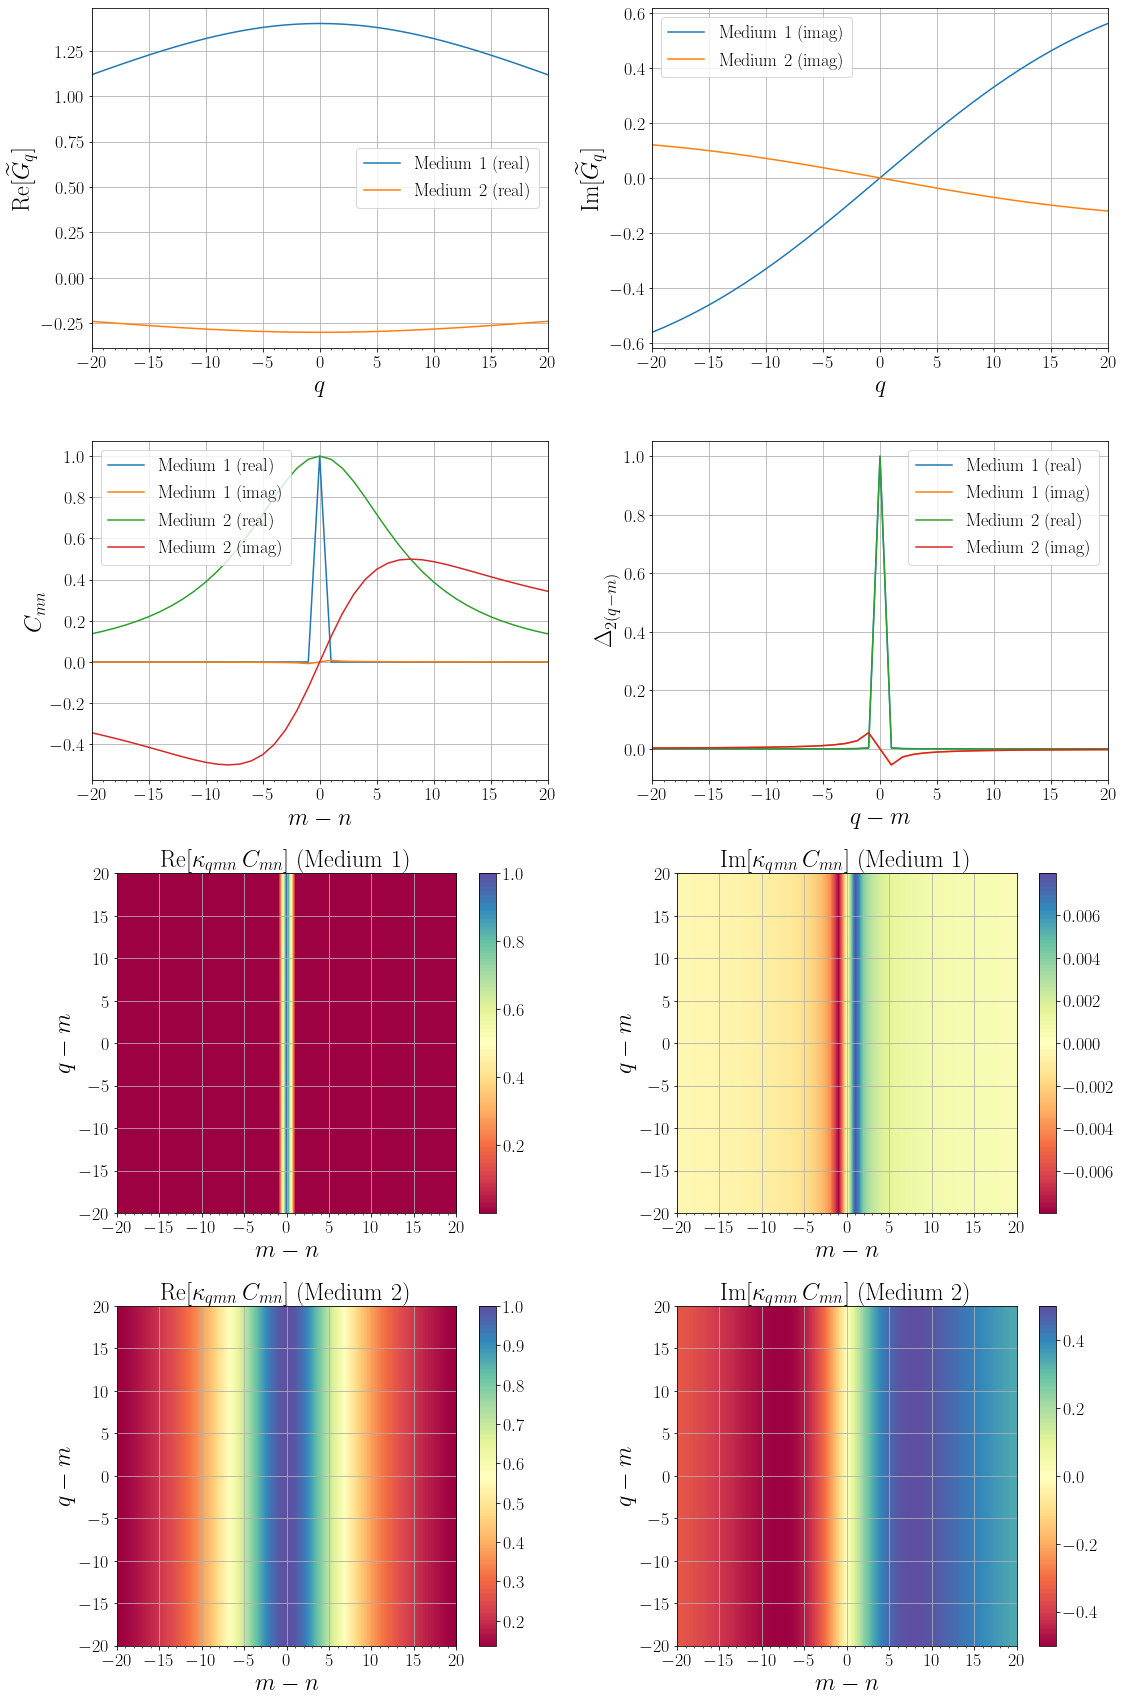

Elapsed time: 2 seconds (DOP853)
Derivative function calls: 506 (2.53e+02 calls/sec)


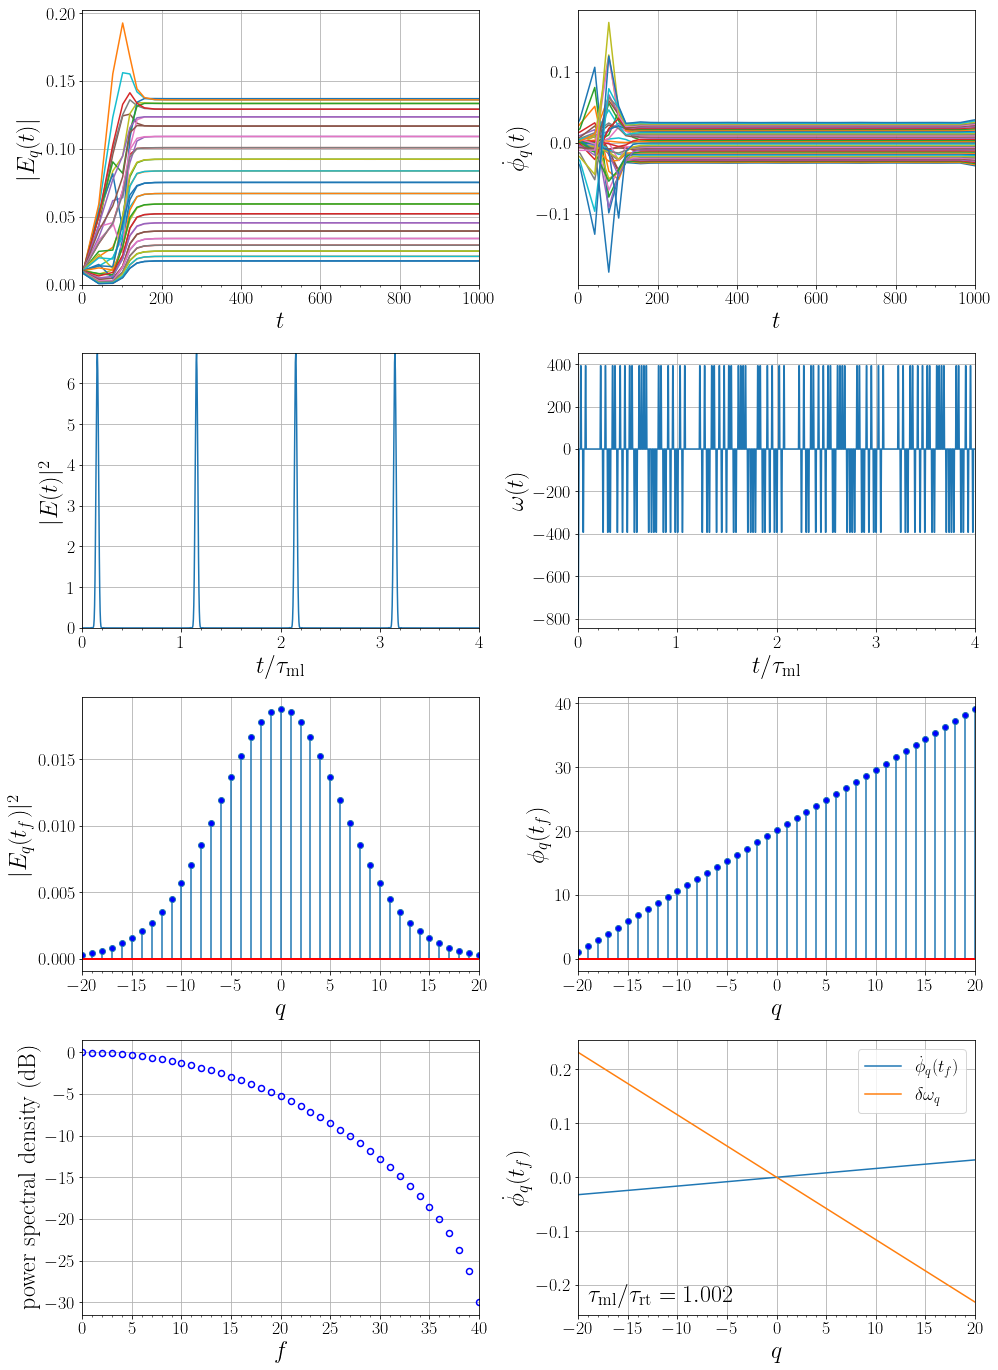

In [10]:
# We'll set up both the amplifier and absorber for AWM operation. Sometimes,
# when absorbers are included in the cavity, FWM fails to converge because
# negative intermodal coupling in the absorber can seem like gain.
config_res = ml.LaserConfigurationURL(params_res)
amplifier = ml.ActiveLaserMediumAWM(params_amp, config_res, freq_shifts)
absorber = ml.ActiveLaserMediumAWM(params_abs, config_res, freq_shifts)

# In order to include the absorber in the model, we simply add it to the list
# of active laser media when we initialize the model. We can include an arbitray
# number of amplifiers and absorbers this way.
model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier, absorber)
print(model)
model.modplot()

# These laser simulations lock almost immediately, and exhibit the textbook
# gaussian modal amplitudes and linear phase shifts of temporally mode-locked
# lasers.
t_max = 1000
model.integrate(t_max)

## Standing-Wave Laser : Mode-Locked

Elapsed time: 2 seconds (DOP853)
Derivative function calls: 470 (2.35e+02 calls/sec)


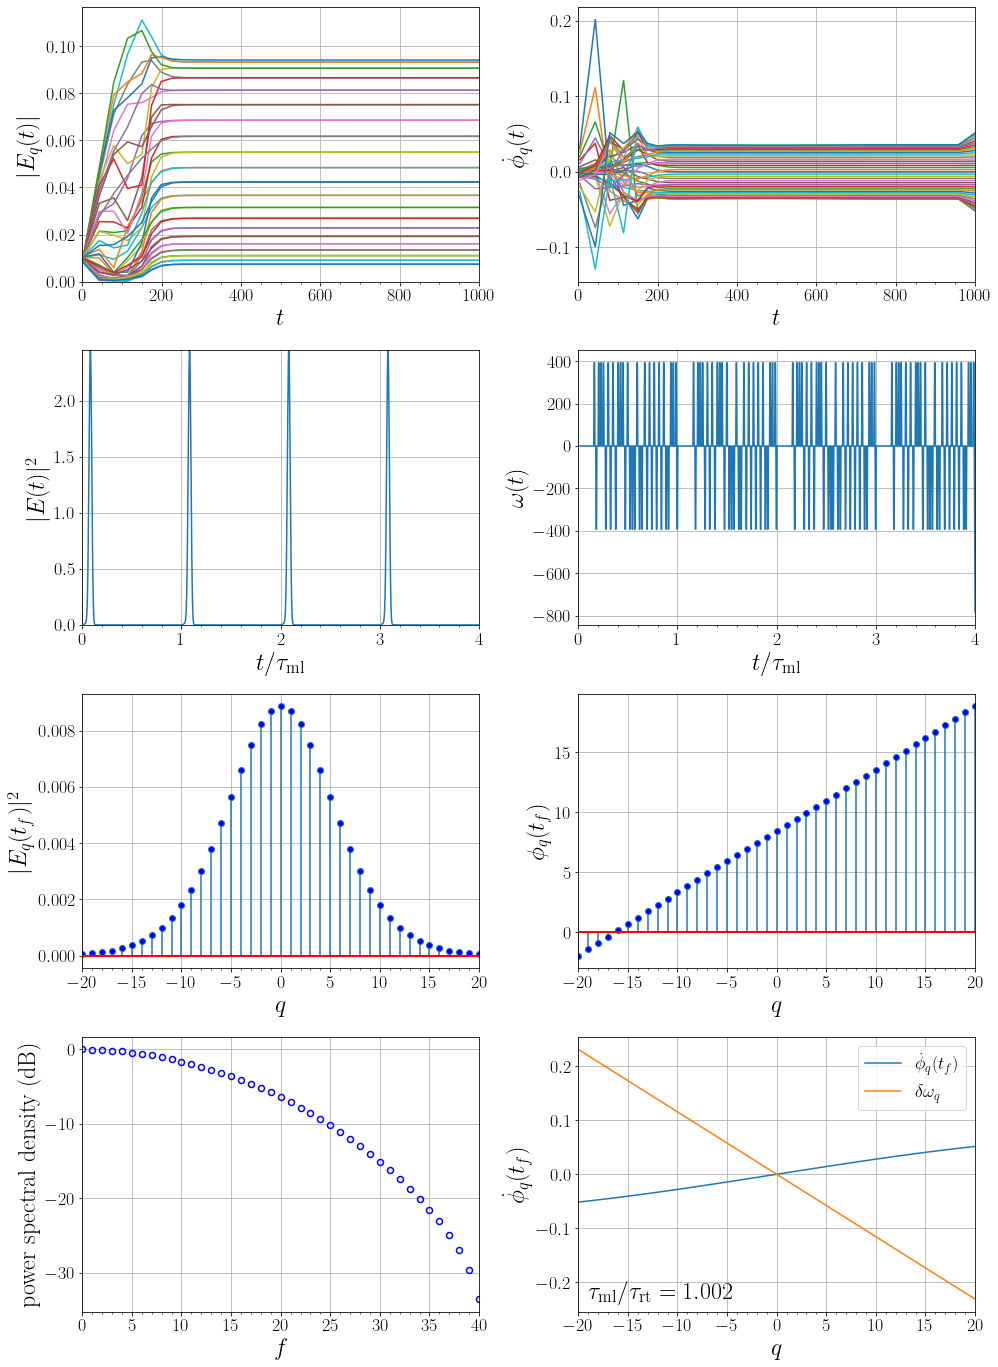

In [11]:
# We see temporal mode-locking for the SWL as well.
config_res = ml.LaserConfigurationSWL(params_res)
amplifier = ml.ActiveLaserMediumAWM(params_amp, config_res, freq_shifts)
absorber = ml.ActiveLaserMediumAWM(params_abs, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier, absorber)
model.integrate(t_max)

## Spatial Hole-Burning: Mode-Locked

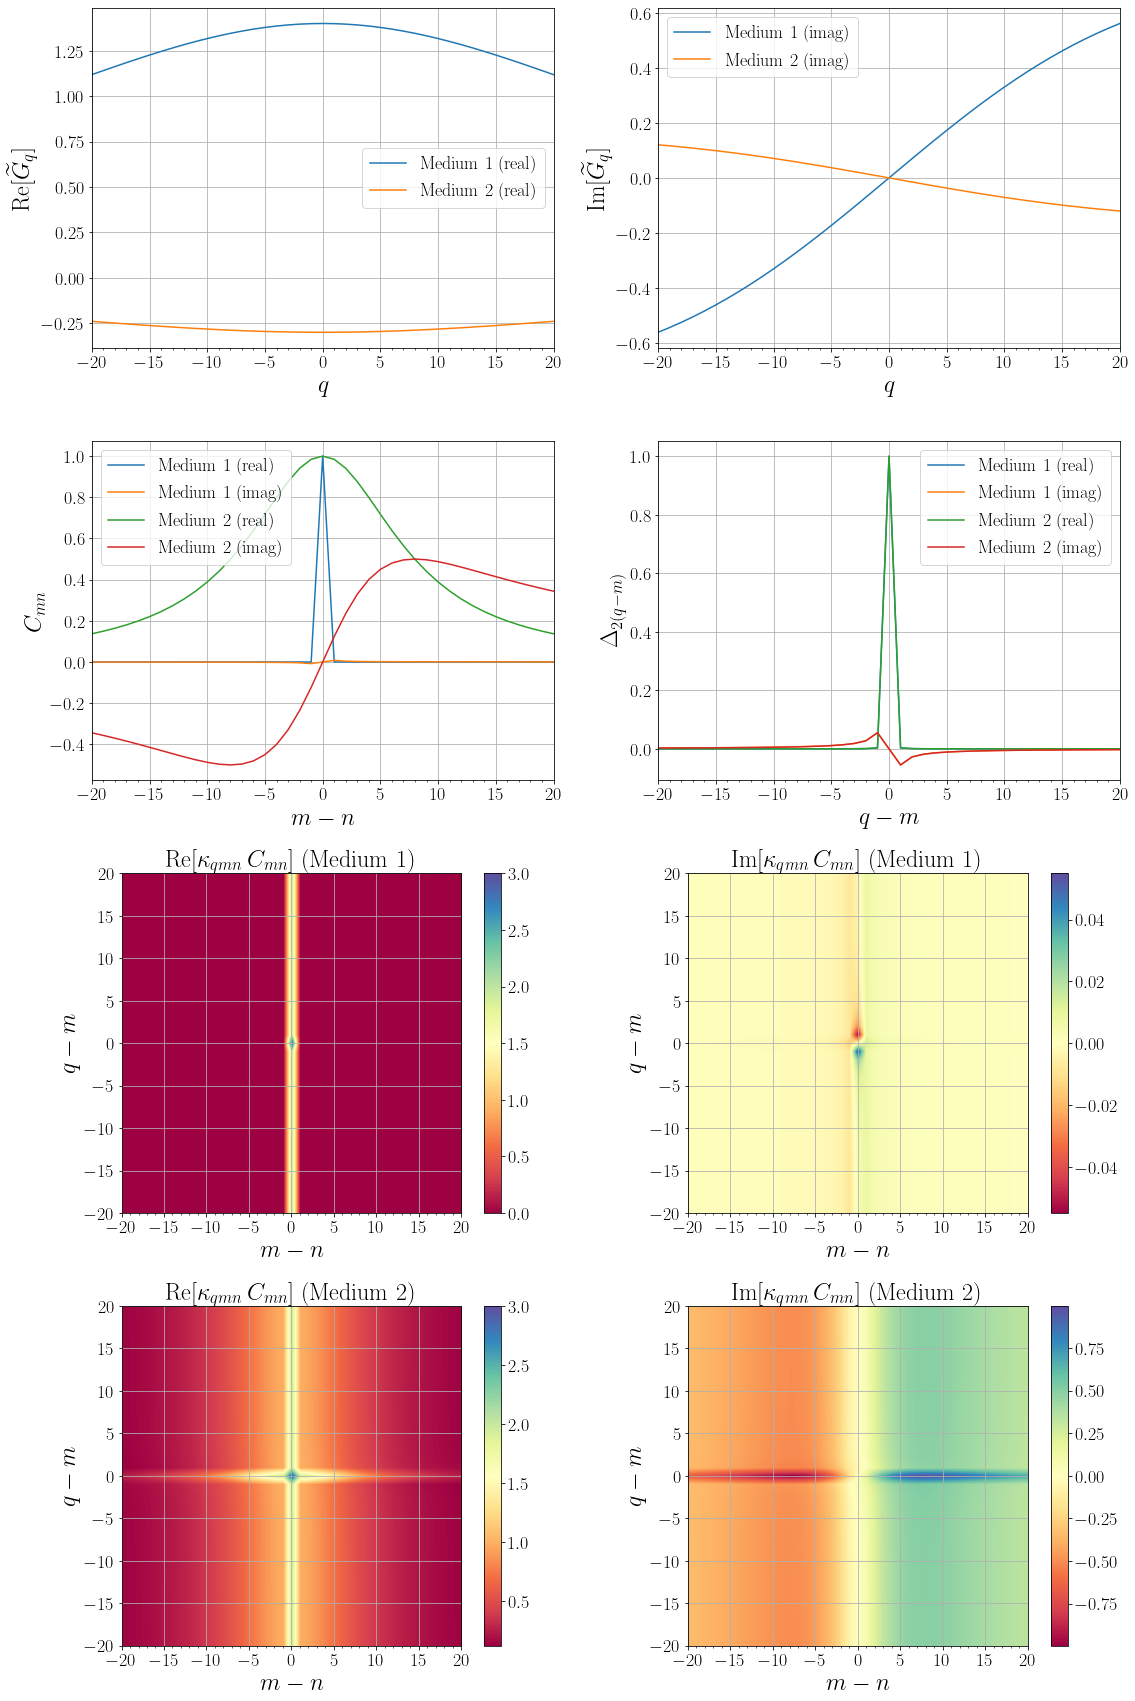

Elapsed time: 2 seconds (DOP853)
Derivative function calls: 458 (2.29e+02 calls/sec)


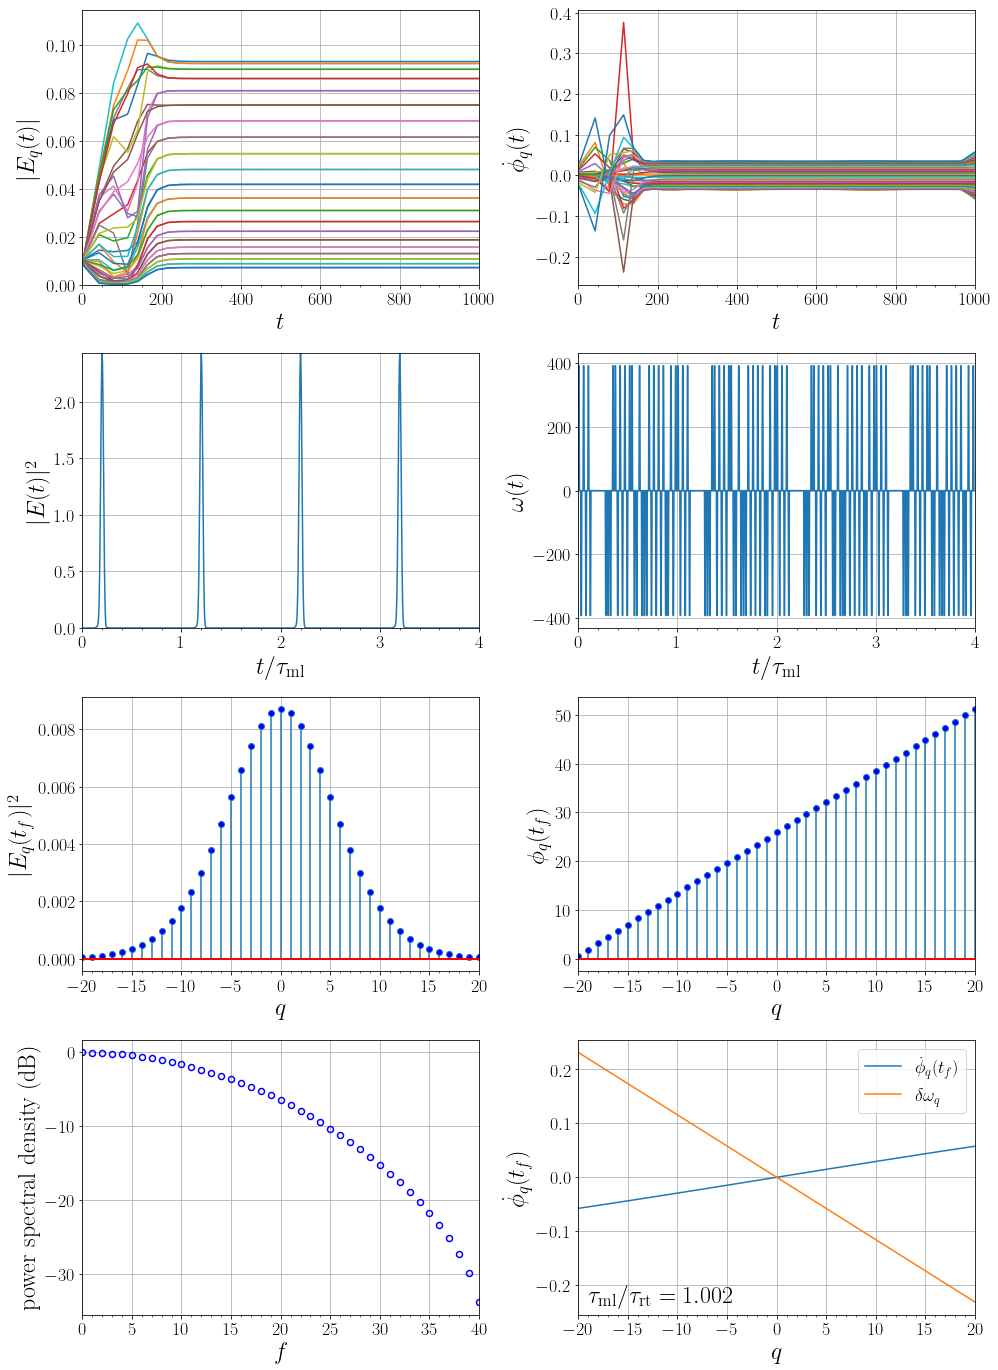

In [12]:
config_res = ml.LaserConfigurationSHB(params_res)
amplifier = ml.ActiveLaserMediumAWM(params_amp, config_res, freq_shifts)
absorber = ml.ActiveLaserMediumAWM(params_abs, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier, absorber)
model.modplot()
model.integrate(t_max)

# Frequency Mode-Locked Laser  
## Let's reduce the gain recovery time significantly; we'll find frequency mode-locking only when we include SHB

## Parameters

In [13]:
r_1 = 0.5
r_2 = 1.0
loss_db = 1.0

tau_grp = 75.0
tau_prp = 0.3/tau_grp
disp = []

tau_par = 1.5/tau_grp   # Now only 5x tau_prp
gbar_0 = 1.2

q_max = 10

params_res = ml.LaserResonatorParameters(r_1, r_2, loss_db)

params_mat = ml.LaserMaterialParametersFLL(tau_par, gbar_0)

freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)

## Unidirectional Ring Laser : Single-Mode

ModeLockedLaserModel

LaserResonatorParameters
R_1 = 0.5; R_2 = 1.0; loss_db = 1.0 dB; tau_pho/tau_grp = 1.08

FrequencyShifts
q = [-10, 10]; tau_prp/tau_grp = 0.004; tau_prp/tau_pho = 0.00369; alpha = 0.0

ActiveLaserMediumFWM
LaserConfigurationURL
LaserMaterialParametersFLL
tau_par/tau_grp = 0.02; Gbar_0 = 1.2; alpha = 0.0; I_sat = 1.0



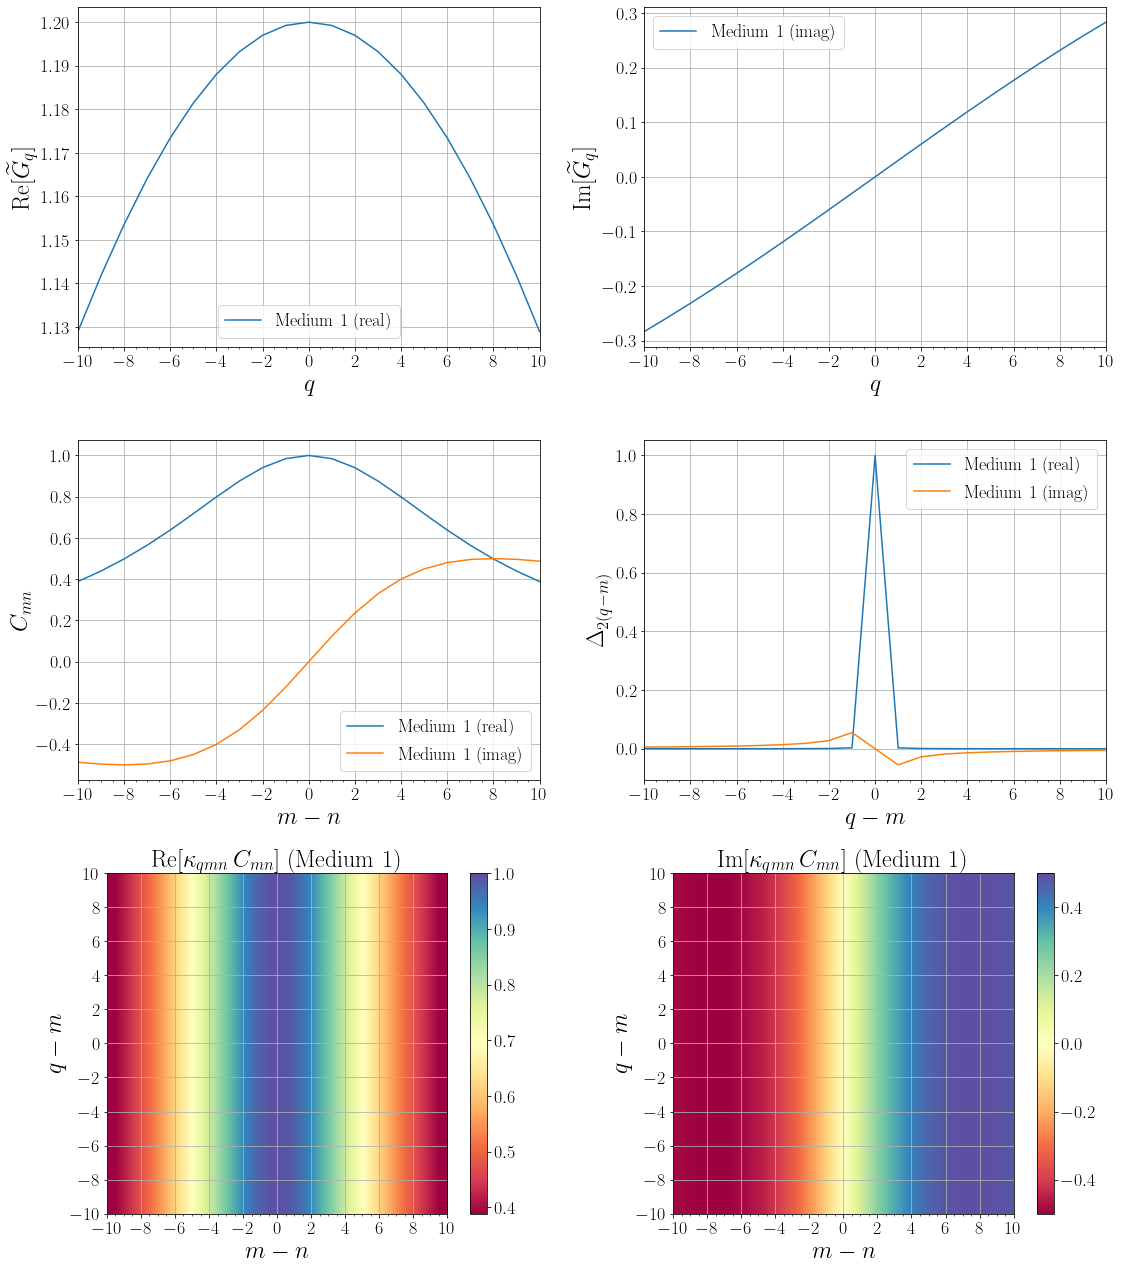

Elapsed time: 0.158 seconds (BDF)
Derivative function calls: 481 (3.04e+03 calls/sec)
Jacobian function calls: 40 (2.53e+02 calls/sec)


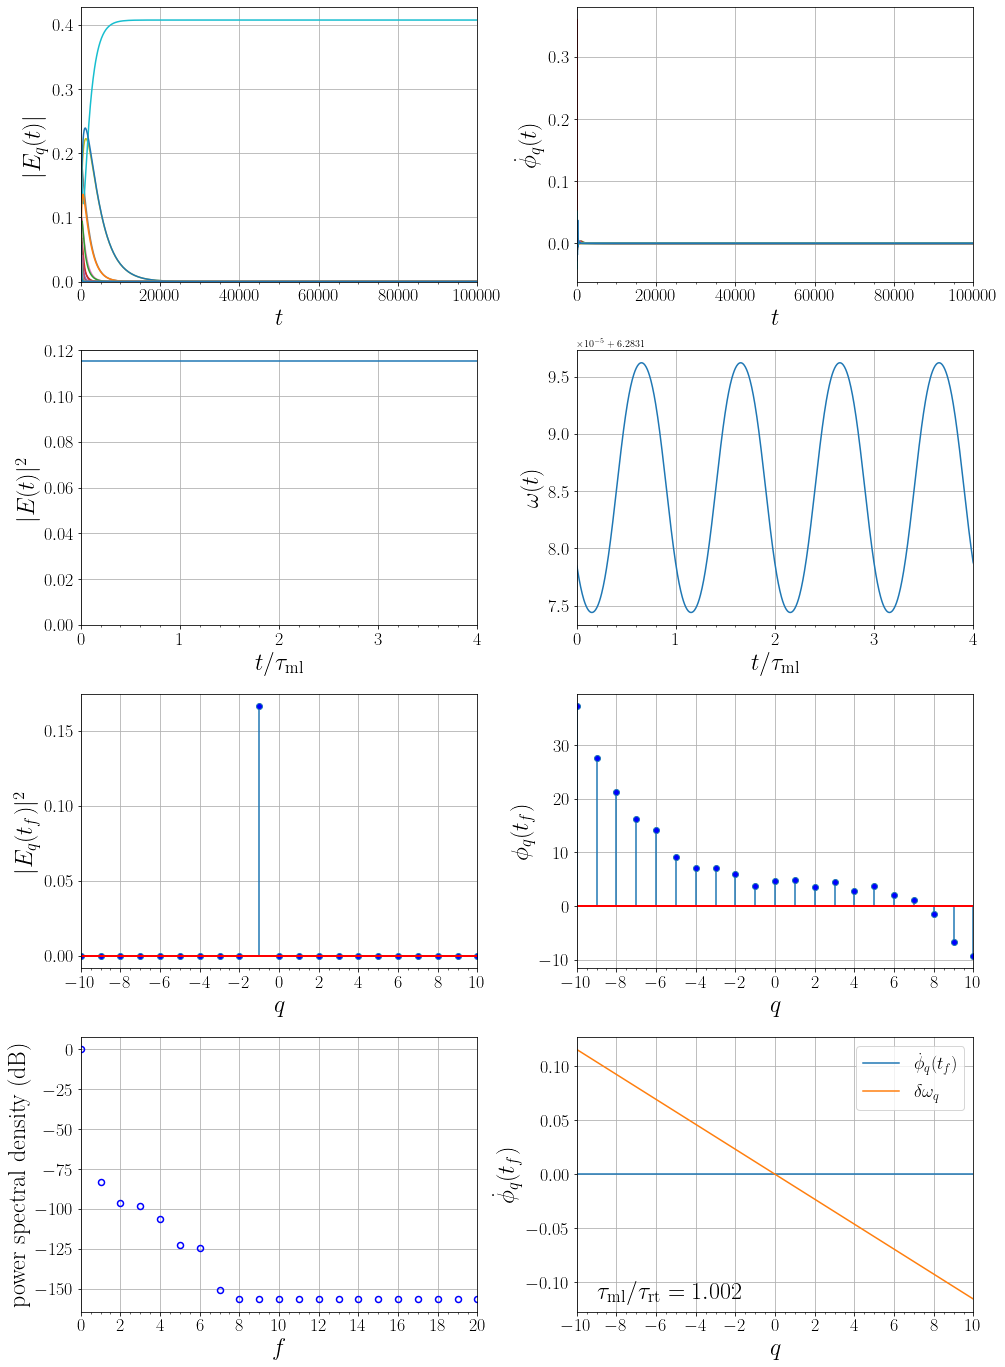

In [14]:
# First, we'll try a URL.
config_res = ml.LaserConfigurationURL(params_res)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
print(model)
model.modplot()

t_max = 100000
model.integrate(t_max, method='BDF')

## Standing-Wave Laser : Single-Mode

Elapsed time: 0.167 seconds (BDF)
Derivative function calls: 455 (2.72e+03 calls/sec)
Jacobian function calls: 29 (1.74e+02 calls/sec)


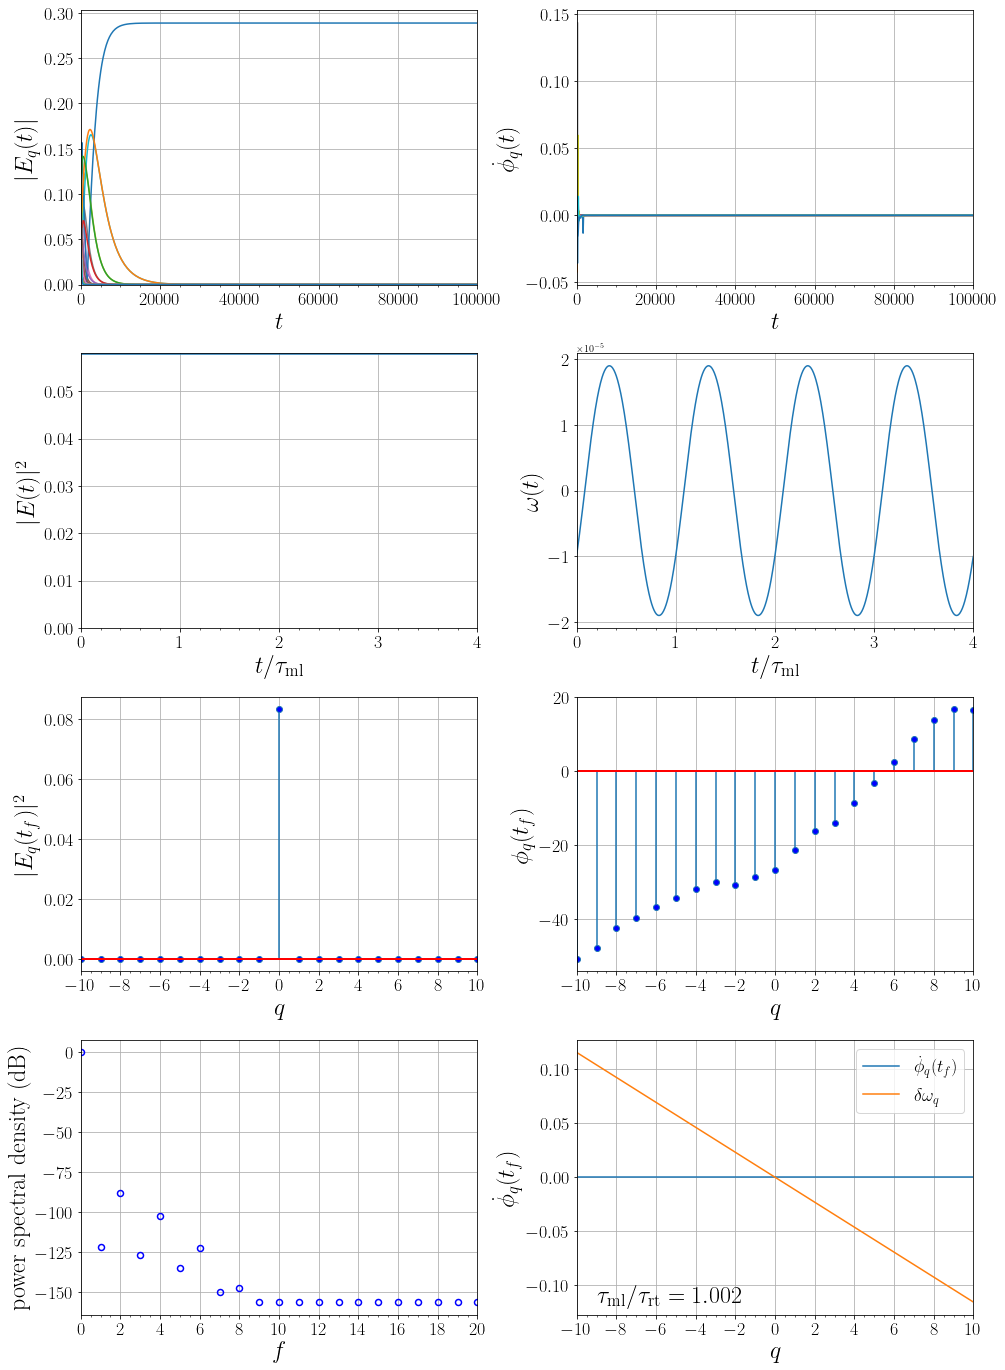

In [15]:
config_res = ml.LaserConfigurationSWL(params_res)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
model.integrate(t_max, method='BDF')

## Spatial Hole-Burning : Mode-Locked

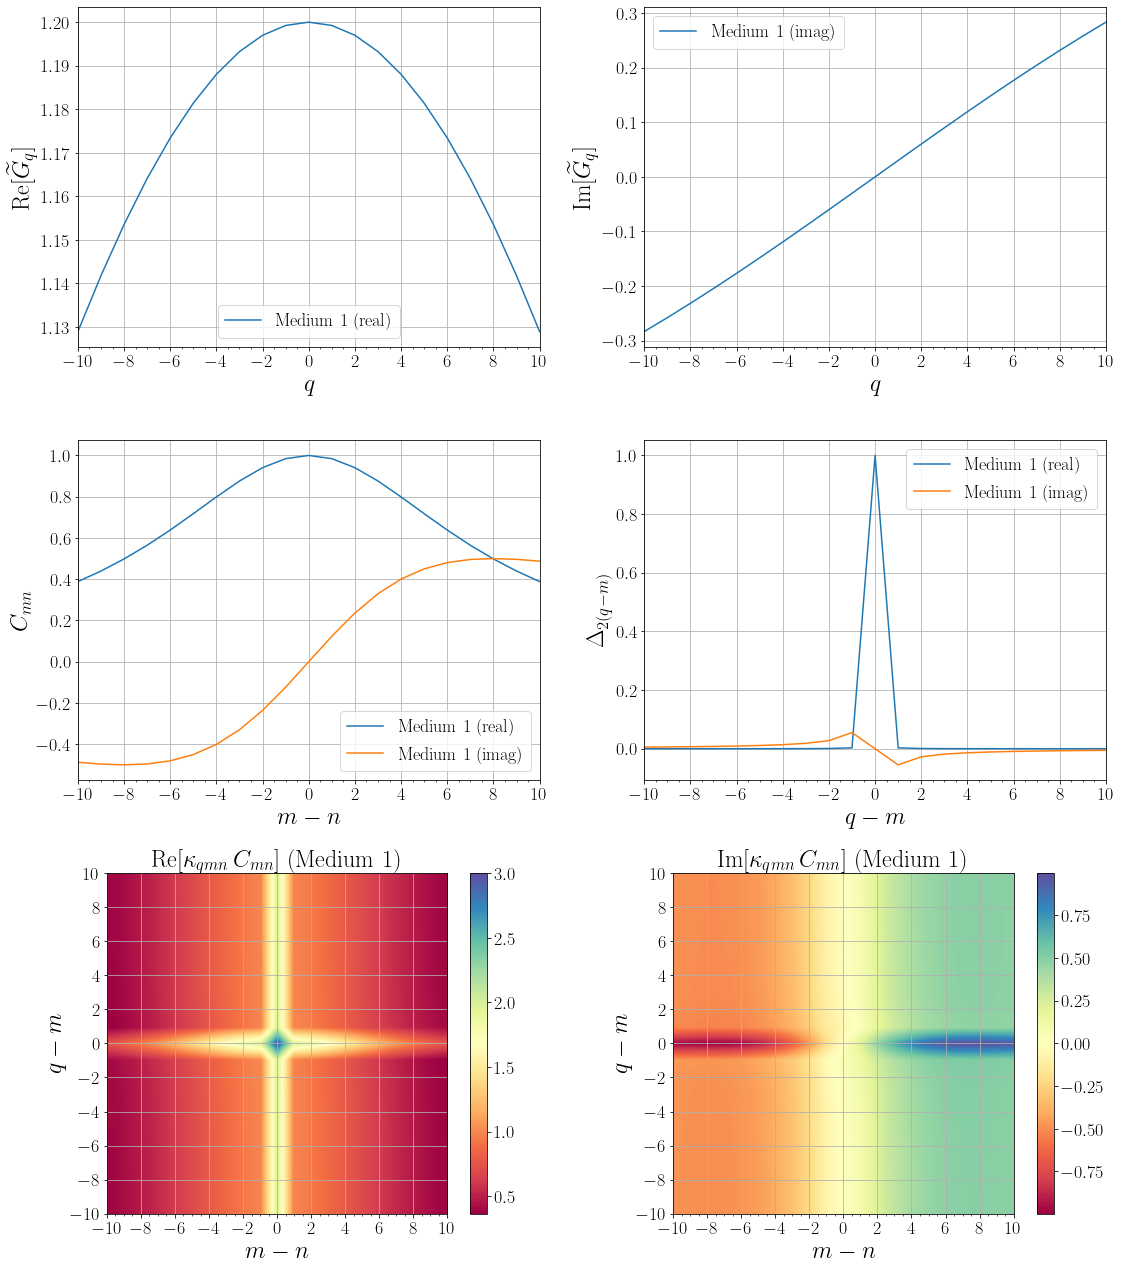

Elapsed time: 5 seconds (BDF)
Derivative function calls: 16501 (3.3e+03 calls/sec)
Jacobian function calls: 1595 (3.19e+02 calls/sec)


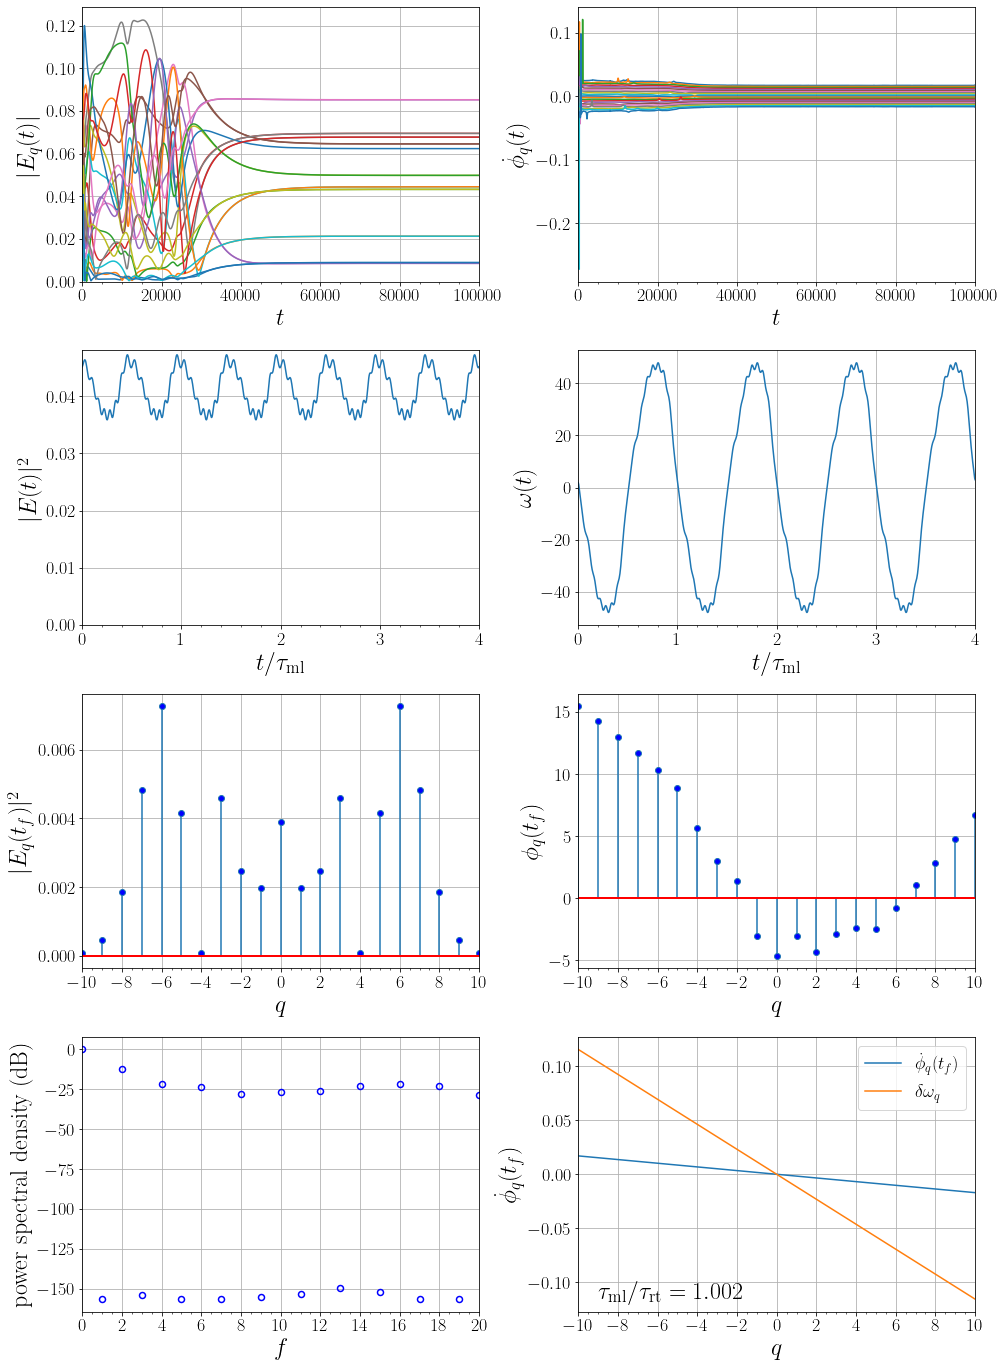

In [16]:
# Now introduce SHB. The result is a "Bessel comb."
config_res = ml.LaserConfigurationSHB(params_res)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
model.modplot()
model.integrate(t_max, method='BDF')

Elapsed time: 0.347 seconds (BDF)
Derivative function calls: 1038 (2.99e+03 calls/sec)
Jacobian function calls: 118 (3.4e+02 calls/sec)


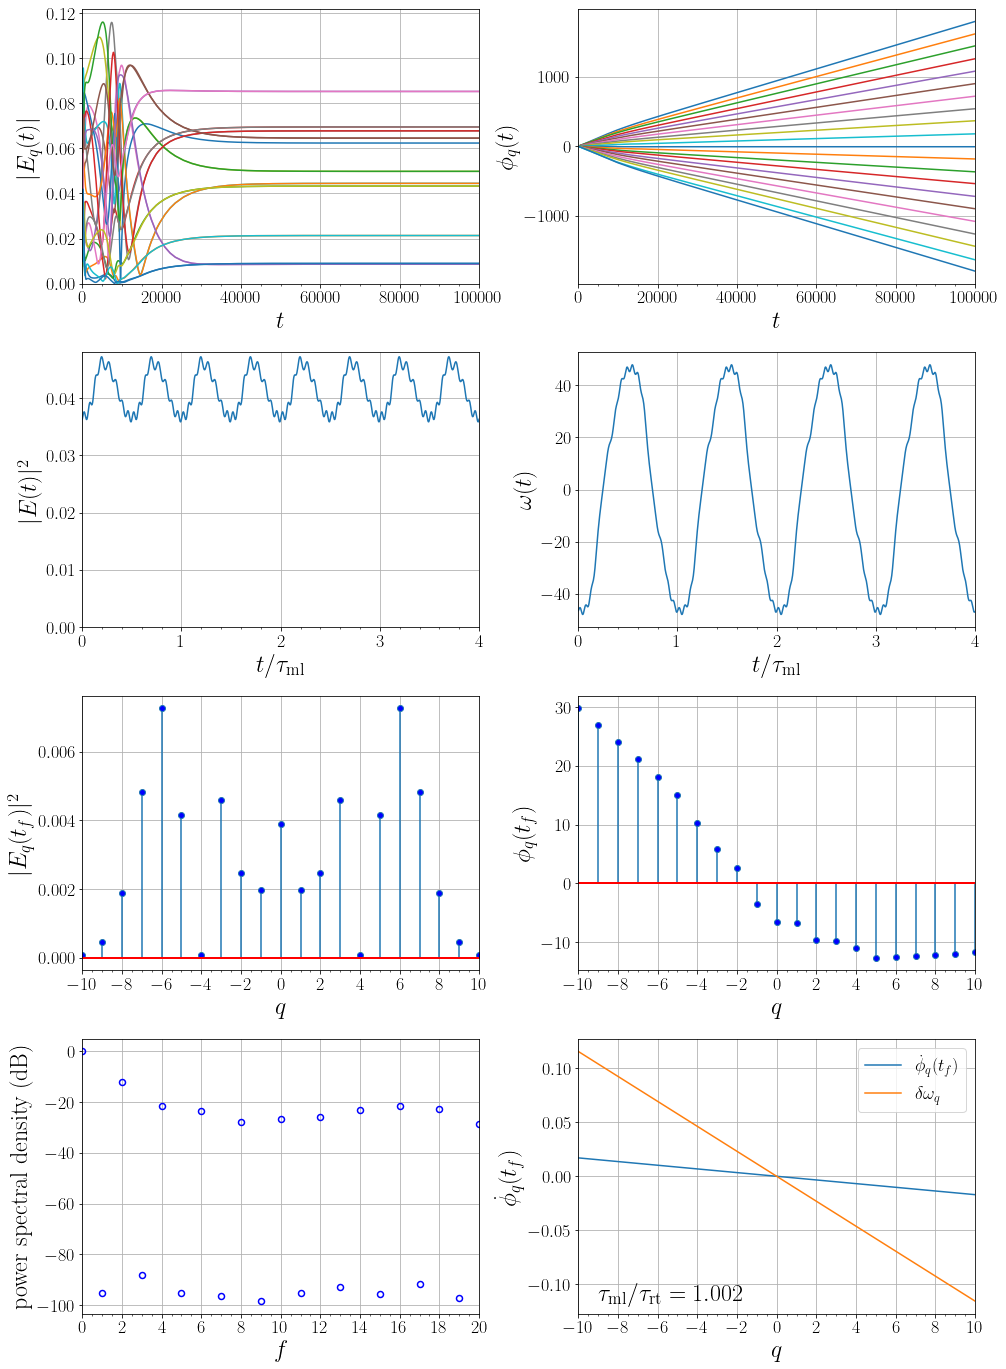

In [17]:
# When the amplitudes of the field modes are appreciable,
# we often get better performance by using the amplitude
# and phase of the field as the dynamical variables, instead
# of the real and imaginary parts.
model.integrate(t_max, method='BDF', usepolar=True)

Elapsed time: 31 seconds (BDF)
Derivative function calls: 15607 (5.03e+02 calls/sec)
Jacobian function calls: 1485 (47.9 calls/sec)


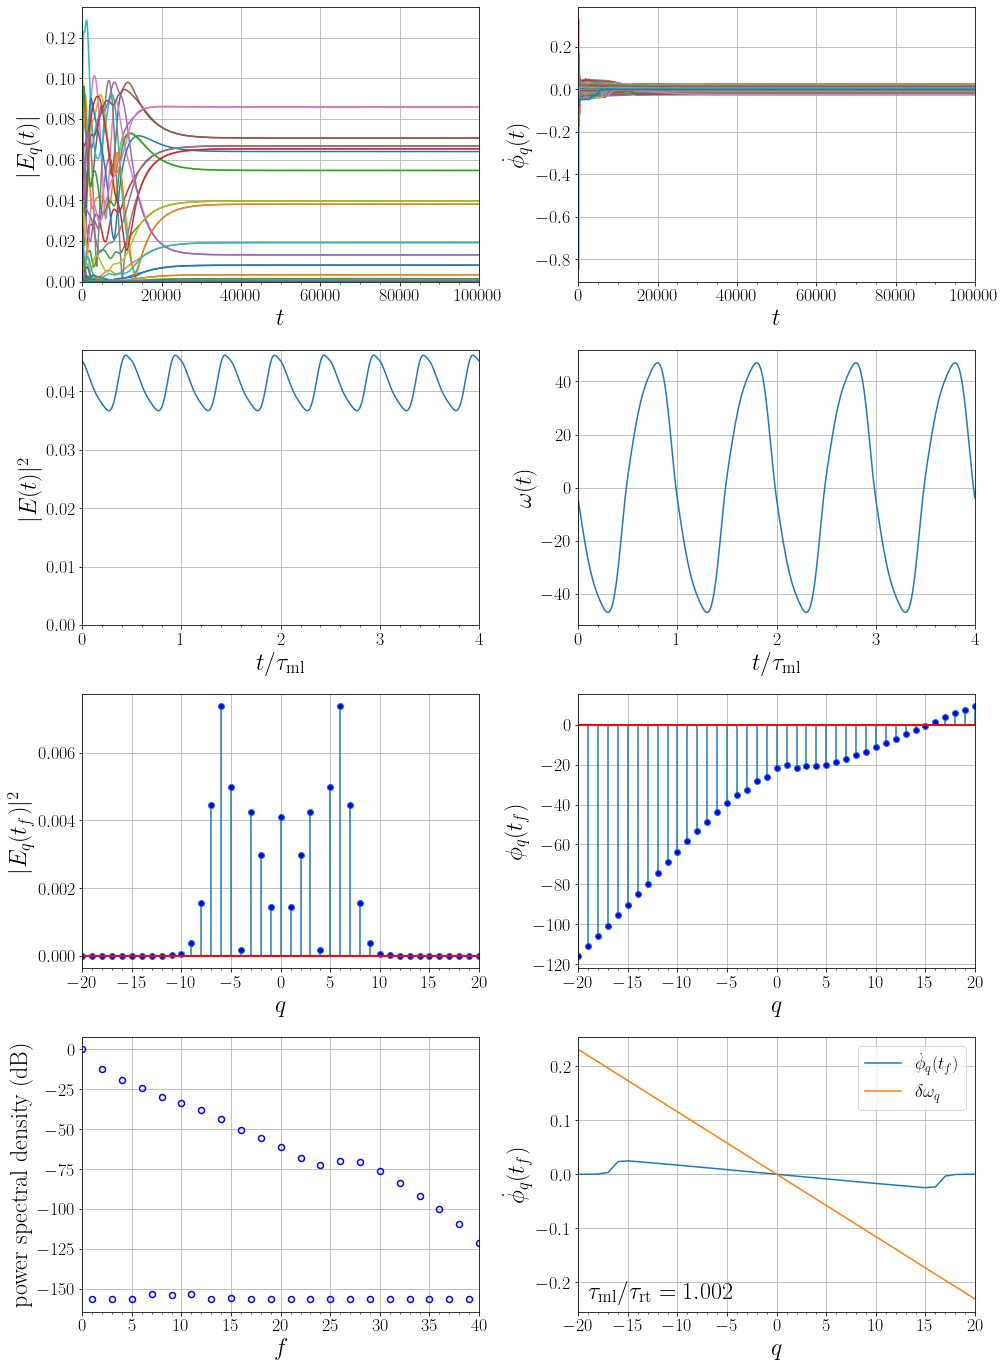

In [18]:
# The slightly ragged output field is usually the result of too few modes.
# Note that the shape of the comb doesn't change significantly as we increase
# the number of modes in the simulation. Howvever, be aware that the simulation
# time scales as t_max * q_max**3.
q_max = 20
freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)

params_res = ml.LaserResonatorParameters(r_1, r_2, loss_db)
config_res = ml.LaserConfigurationSHB(params_res)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
model.integrate(t_max, method='BDF')

Elapsed time: 2 minutes, 4 seconds (BDF)
Derivative function calls: 56230 (4.53e+02 calls/sec)
Jacobian function calls: 5321 (42.9 calls/sec)


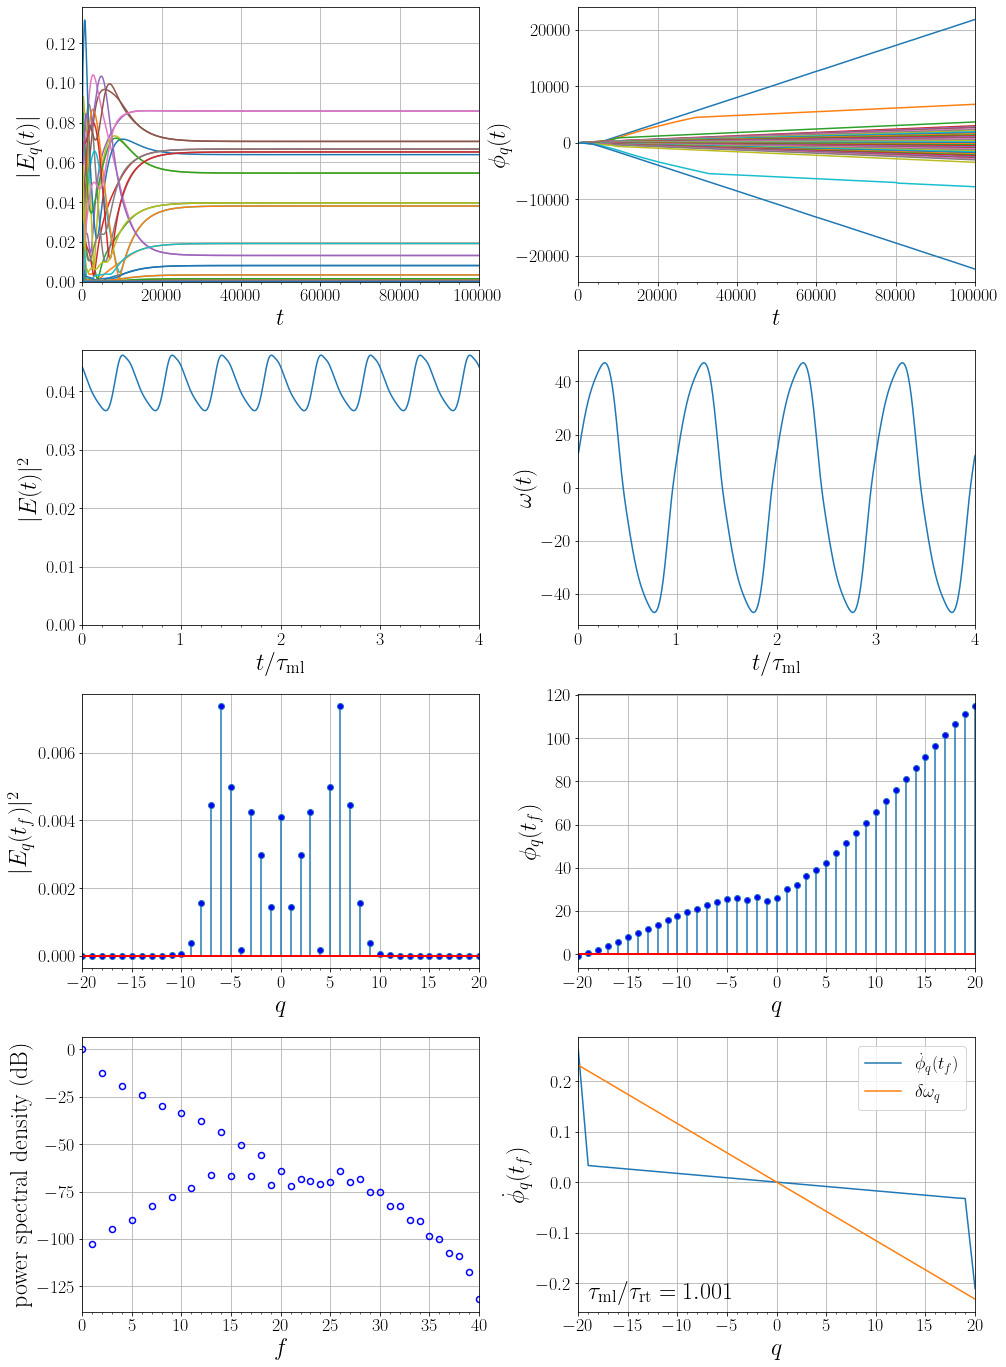

In [19]:
# The presence of many modes with very small amplitudes
#  reduces the effectiveness of the polar method.
model.integrate(t_max, method='BDF', usepolar=True)

# Frequency Mode-Locked QCL w/Dispersion
## Let's look at the way dispersion can influence mode-locking, using the mid-infrared quantum cascade laser as an example

ModeLockedLaserModel

LaserResonatorParameters
R_1 = 0.3; R_2 = 0.3; loss_db = 13.9 dB; tau_pho/tau_grp = 0.178

FrequencyShifts
q = [-20, 20]; tau_prp/tau_grp = 0.000769; tau_prp/tau_pho = 0.00431; alpha = 0.0
D_2 = 0.0

ActiveLaserMediumFWM
LaserConfigurationSHB
LaserMaterialParametersFLL
tau_par/tau_grp = 0.00769; Gbar_0 = 1.02; alpha = 0.0; I_sat = 1.0



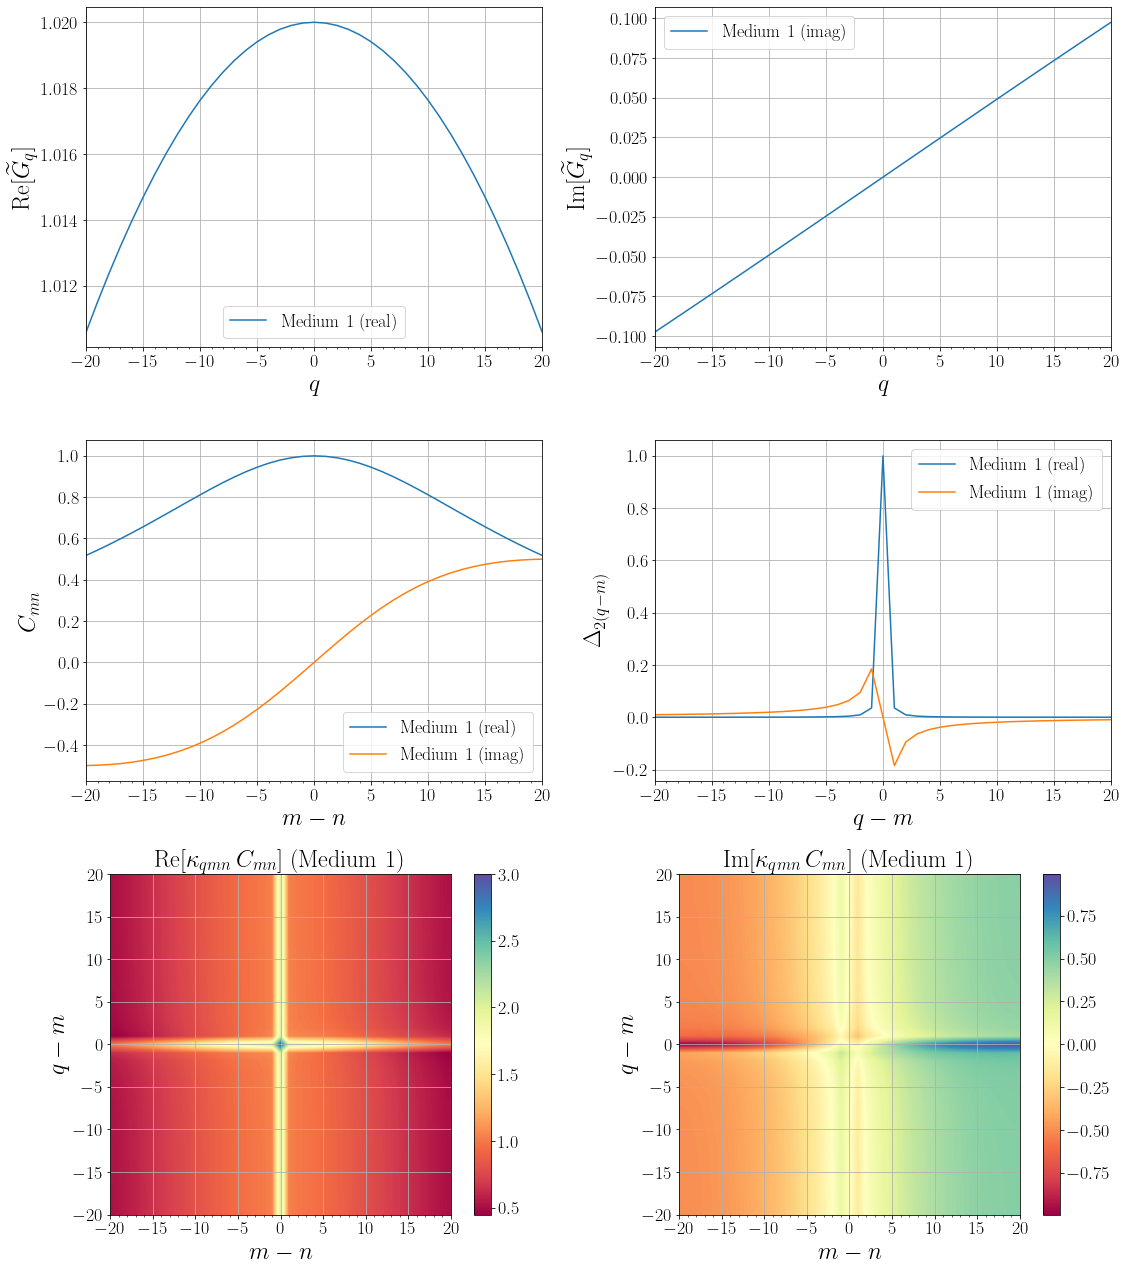

Elapsed time: 9 seconds (BDF)
Derivative function calls: 4769 (5.3e+02 calls/sec)
Jacobian function calls: 485 (53.9 calls/sec)


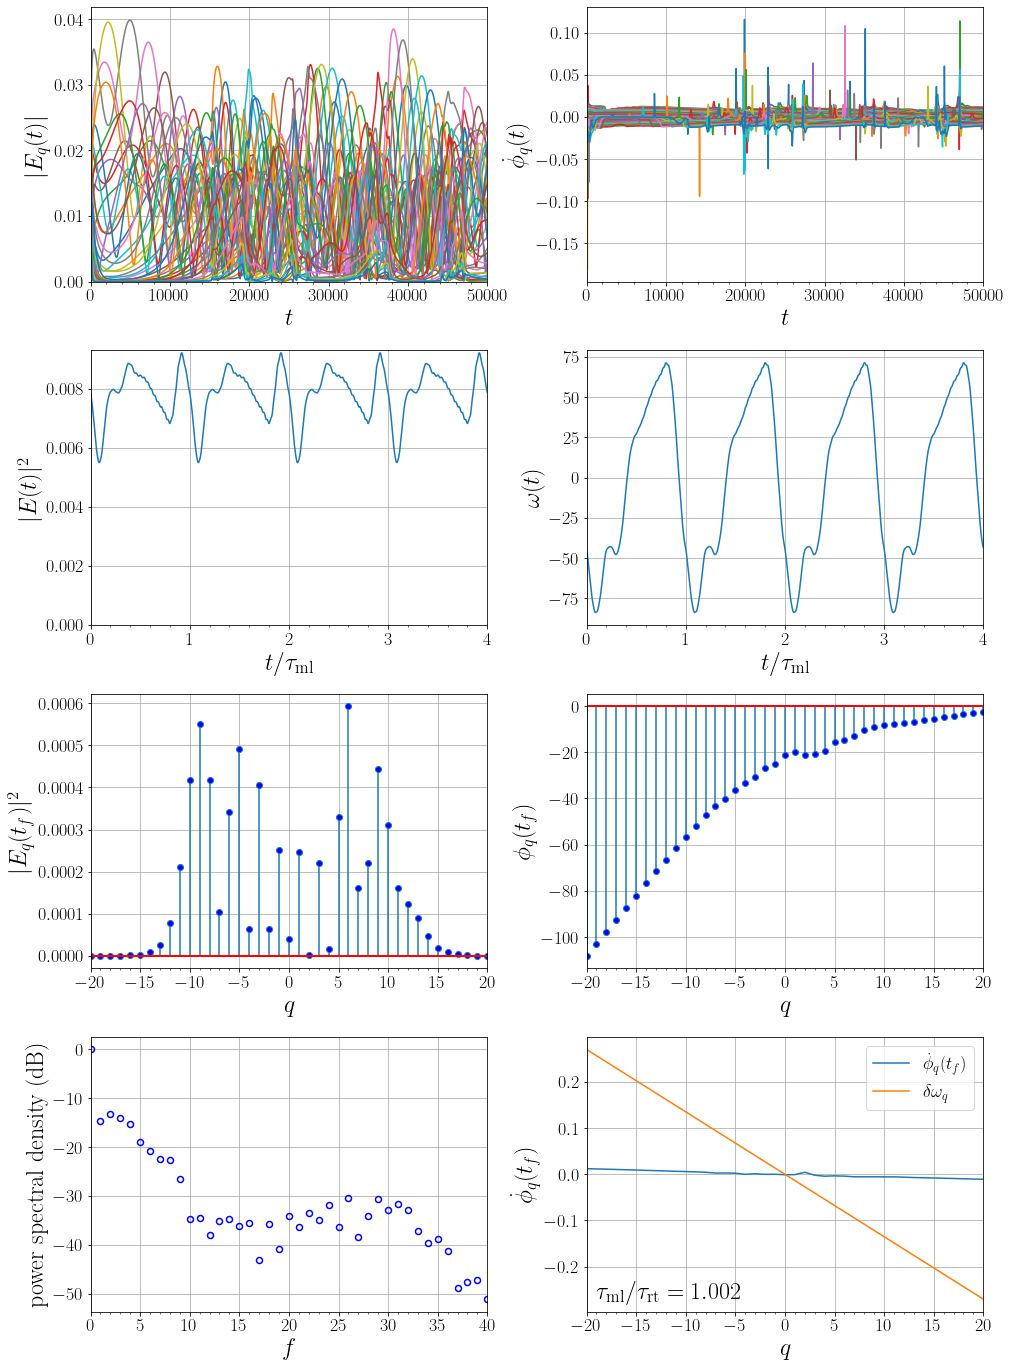

In [20]:
r_1 = 0.3
r_2 = 0.3
loss_db = (0.8 * 40.0) * np.log10(np.e)
disp = [0.0]                # First, set the dispersion to zero

tau_grp = 65.0
tau_prp = 0.05 / tau_grp    # Extremely short transverse relaxation time
tau_par = 0.50 / tau_grp    # Gain recovery time

gbar_0 = 1.02
q_max = 20

params_res = ml.LaserResonatorParameters(r_1, r_2, loss_db)
params_mat = ml.LaserMaterialParametersFLL(tau_par, gbar_0)

config_res = ml.LaserConfigurationSHB(params_res)
freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)

amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)
print(model)
model.modplot()

# Without dispersion, the laser doesn't lock
t_max = 50000
model.integrate(t_max, method='BDF')

Elapsed time: 9 seconds (BDF)
Derivative function calls: 4287 (4.76e+02 calls/sec)
Jacobian function calls: 433 (48.1 calls/sec)


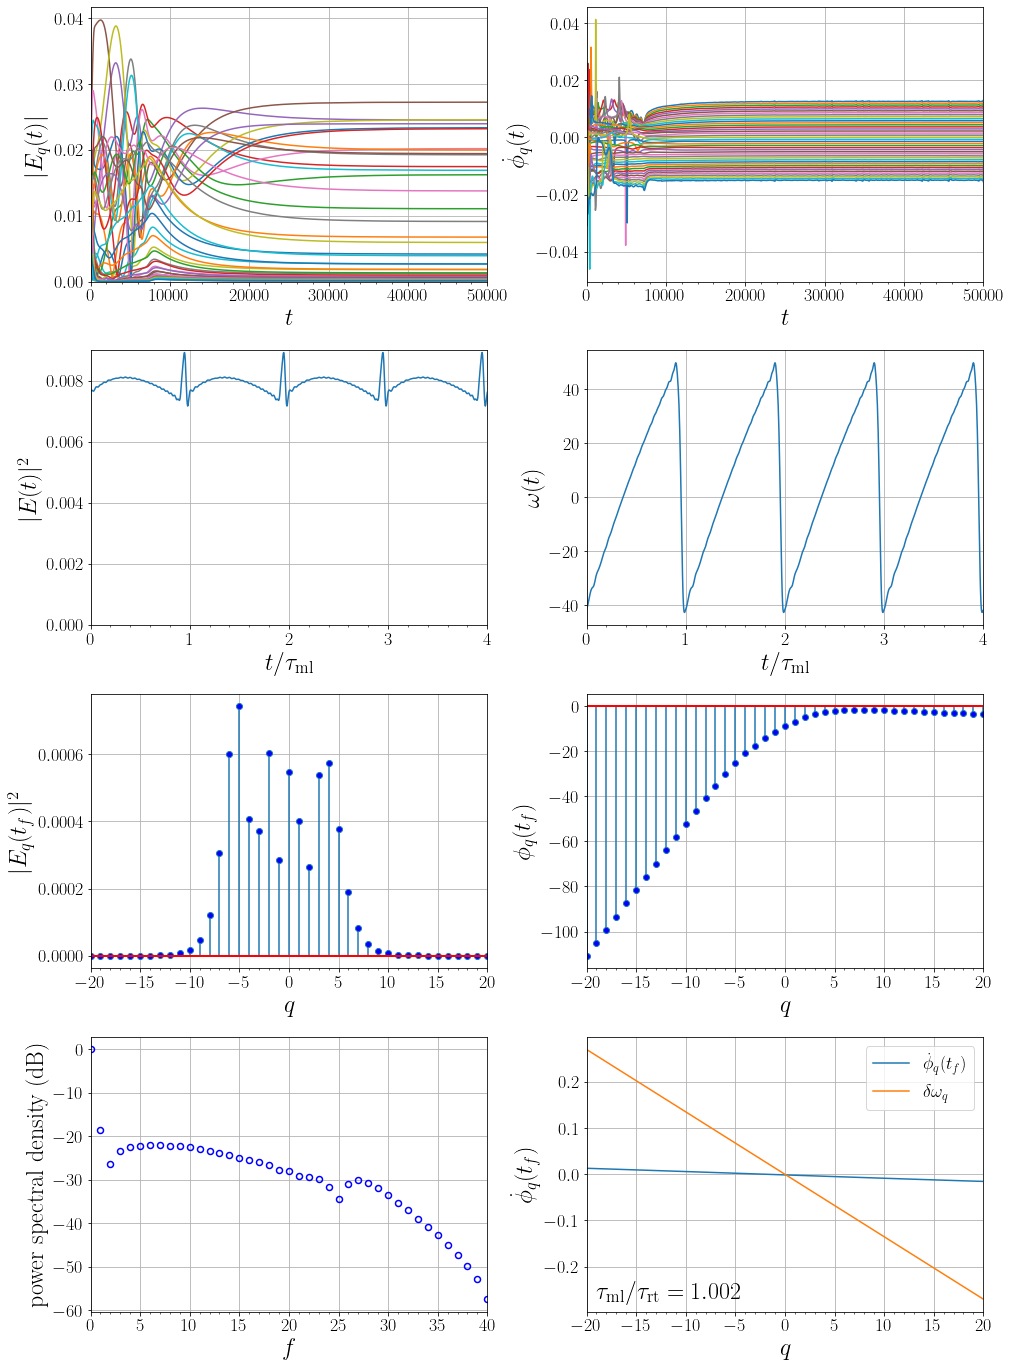

In [21]:
# Now we introduce a small amount of dispersion
disp = [-1.5e-06]            # Dimensionless group-velocity dispersion (see notes)

freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)
model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)

# Note the non-Bessel comb and the linear frequency chirp of the output field
model.integrate(t_max, method='BDF')

Elapsed time: 9 seconds (BDF)
Derivative function calls: 4012 (4.46e+02 calls/sec)
Jacobian function calls: 419 (46.6 calls/sec)


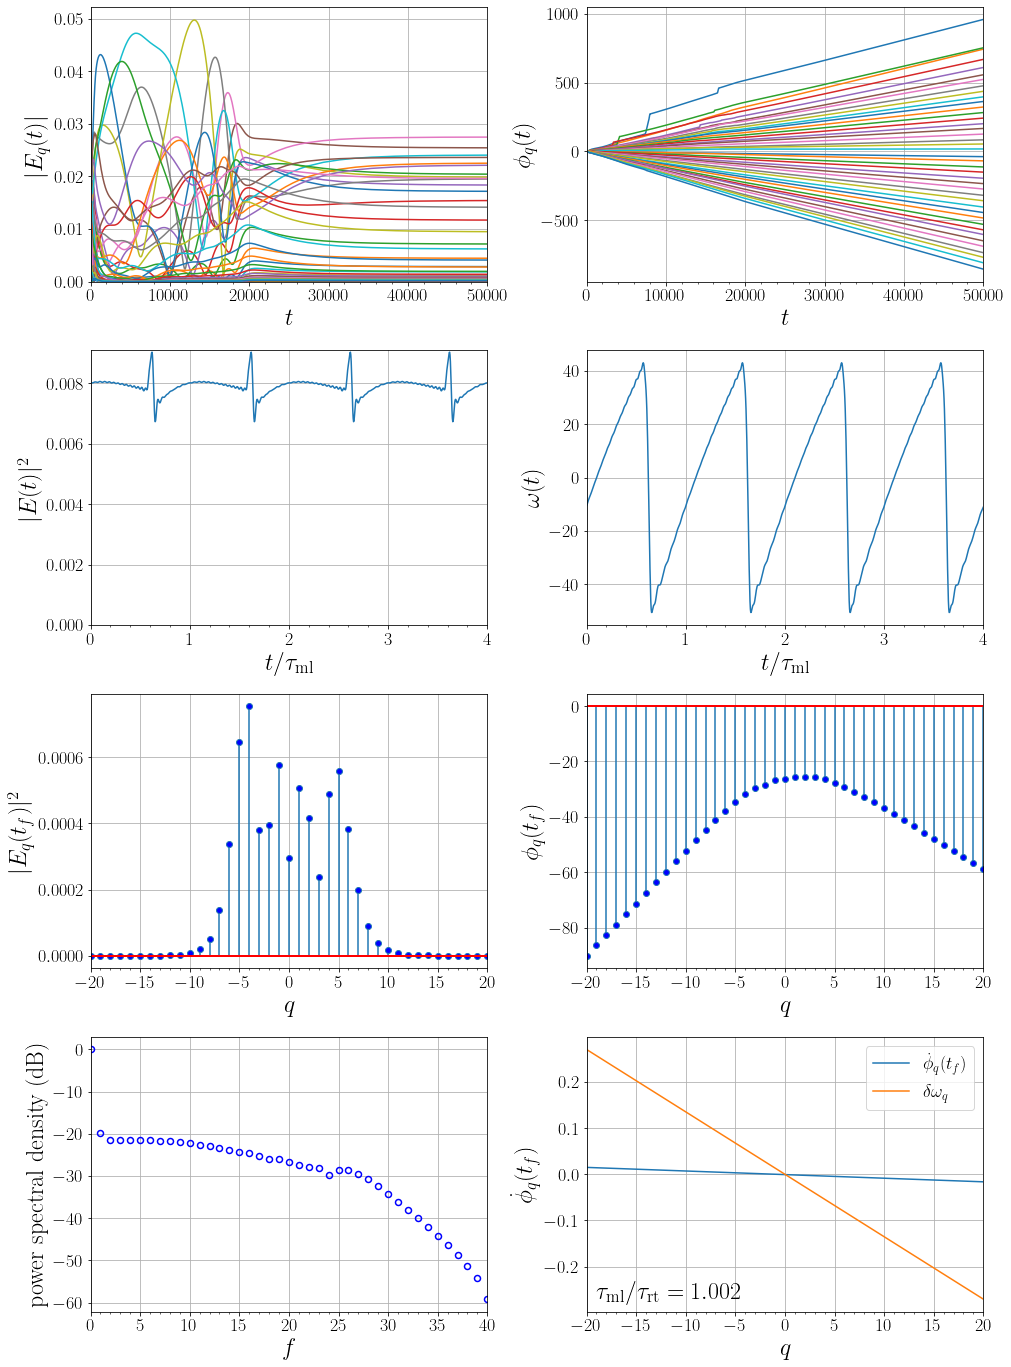

In [22]:
# In this case, the polar method is also quite fast.
model.integrate(t_max, method='BDF', usepolar=True)

Elapsed time: 10 seconds (BDF)
Derivative function calls: 4525 (4.52e+02 calls/sec)
Jacobian function calls: 475 (47.5 calls/sec)


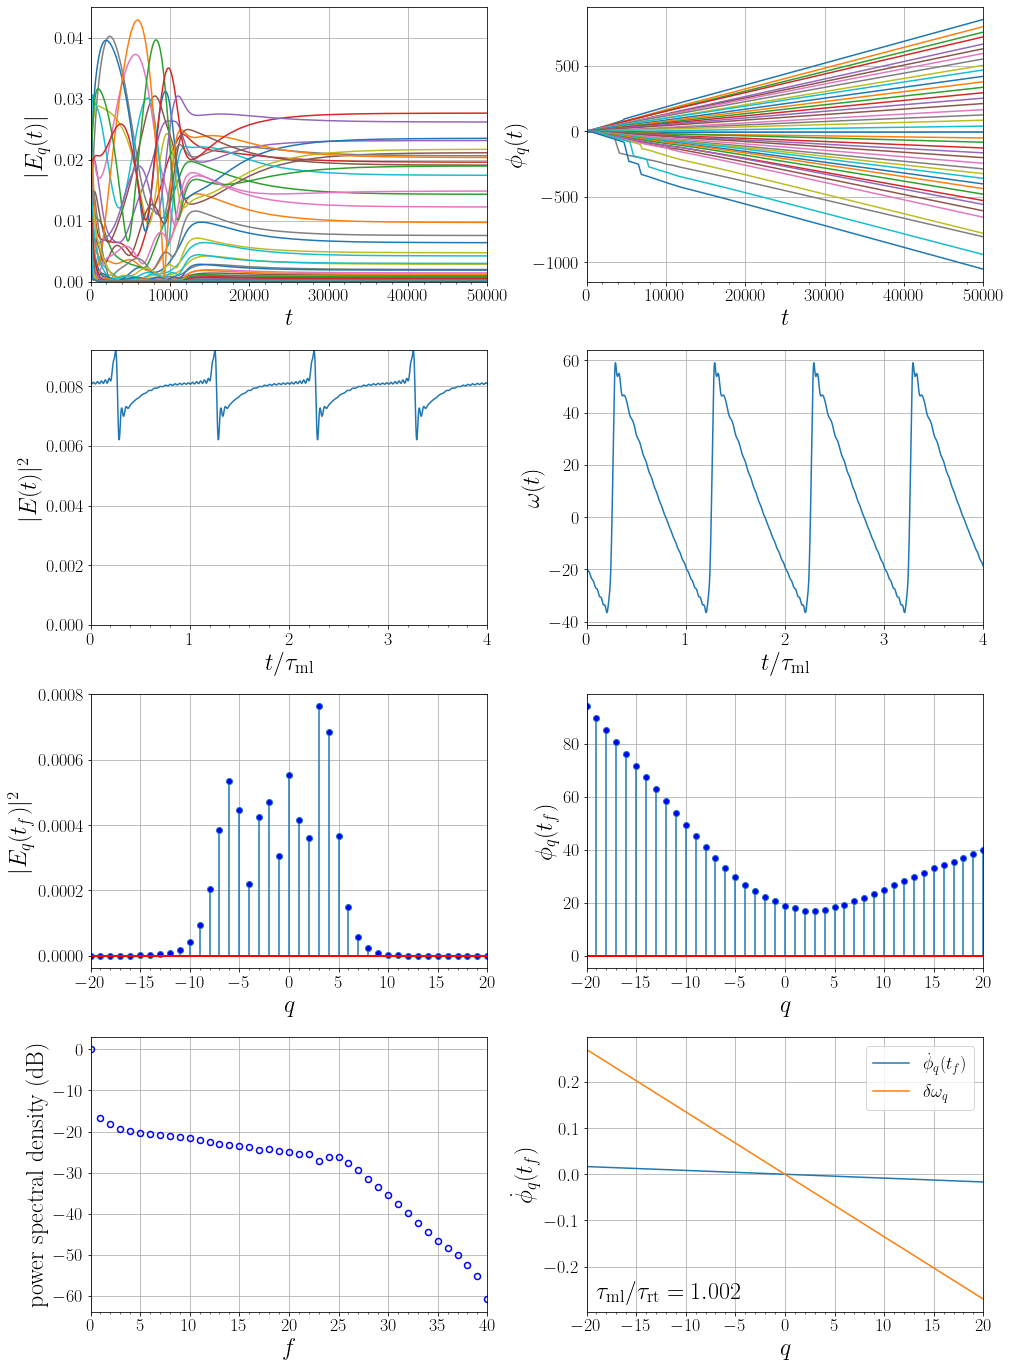

In [23]:
# Changing the sign of the dispersion changes the sign of the frequency
# chirp and horizontally reflects the comb
disp = [1.5e-06]

freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)
model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)

model.integrate(t_max, method='BDF', usepolar=True)

Elapsed time: 1 minutes, 19 seconds (BDF)
Derivative function calls: 14071 (1.78e+02 calls/sec)
Jacobian function calls: 1199 (15.2 calls/sec)


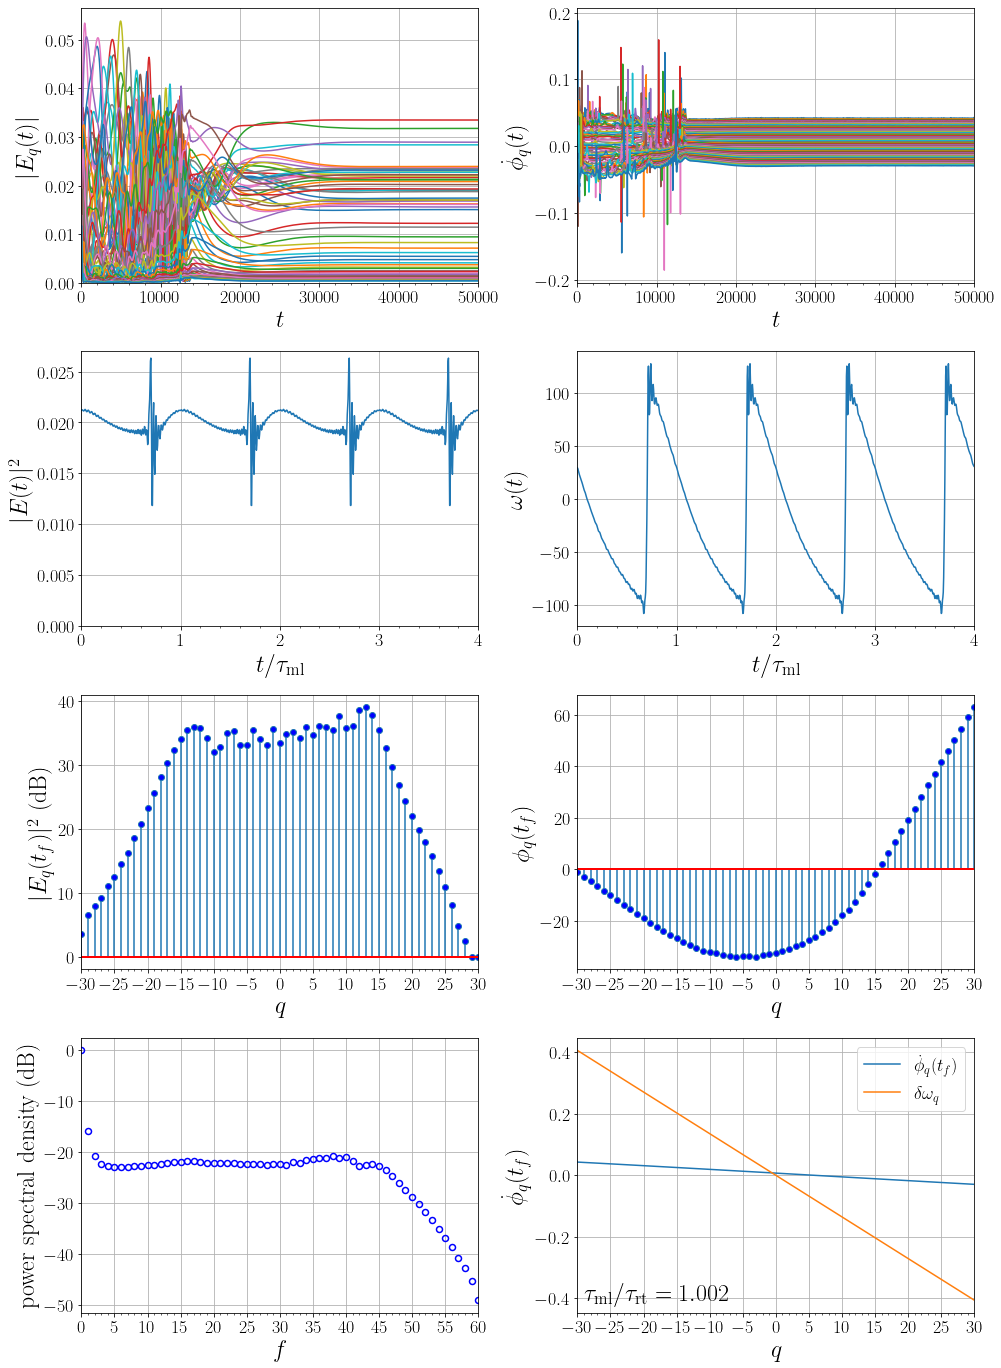

In [24]:
# We can increase the gain, but we need to increase the number of modes as well.
gbar_0 = 1.05
q_max = 30

params_mat = ml.LaserMaterialParametersFLL(tau_par, gbar_0)
freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)

# This time, we'll display the comb in dB.
model.integrate(t_max, method='BDF', uselog=True)

Elapsed time: 51 seconds (BDF)
Derivative function calls: 8907 (1.75e+02 calls/sec)
Jacobian function calls: 924 (18.1 calls/sec)


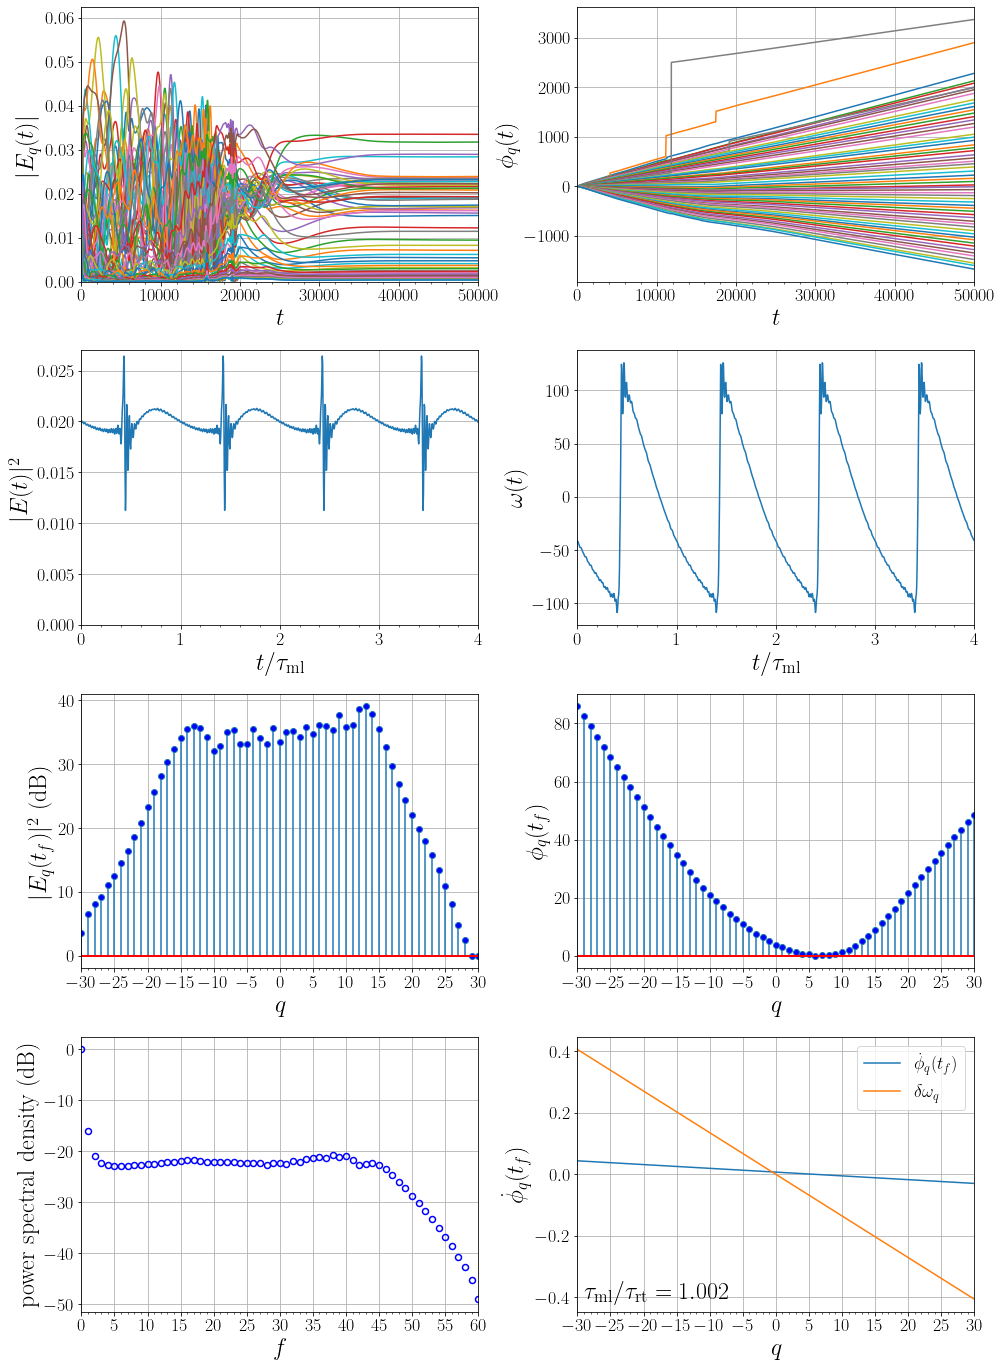

In [25]:
# Again, using the polar method.
model.integrate(t_max, method='BDF', usepolar=True, uselog=True)

Elapsed time: 4 minutes, 41 seconds (BDF)
Derivative function calls: 14176 (50.4 calls/sec)
Jacobian function calls: 1400 (4.98 calls/sec)


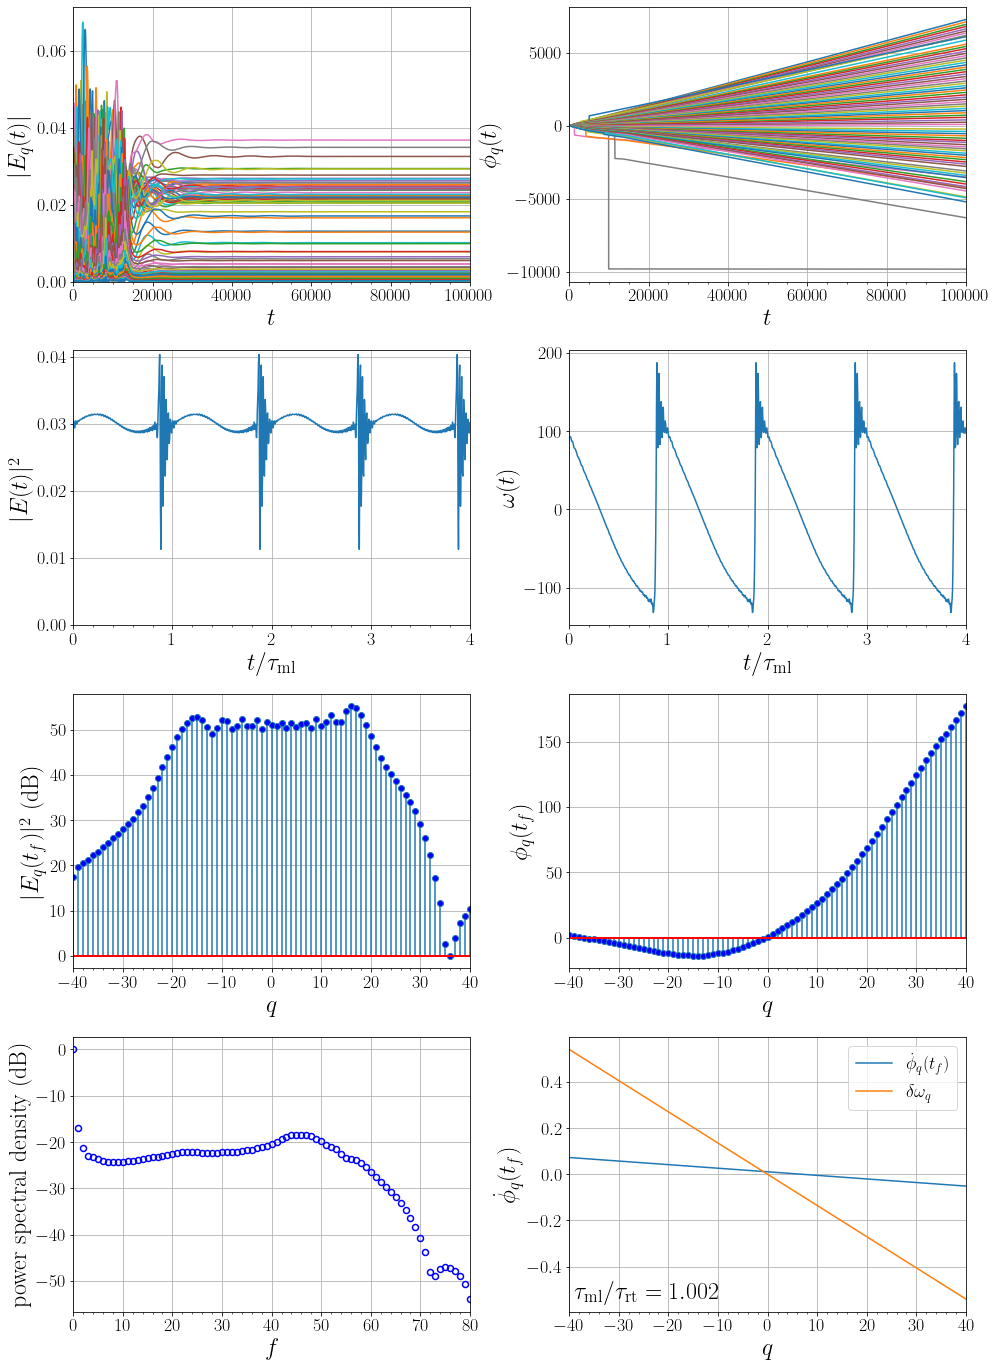

In [26]:
# If something is worth doing, then it's worth overdoing.
gbar_0 = 1.075
q_max = 40

params_mat = ml.LaserMaterialParametersFLL(tau_par, gbar_0)
freq_shifts = ml.FrequencyShifts(-q_max, q_max, tau_prp, params_res.tau_pho, disp, params_mat)
amplifier = ml.ActiveLaserMediumFWM(params_mat, config_res, freq_shifts)

model = ml.ModeLockedLaserModel(params_res, freq_shifts, amplifier)

t_max = 100000
model.integrate(t_max, method='BDF', usepolar=True, uselog=True)

Elapsed time: 14 minutes, 38 seconds (BDF)
Derivative function calls: 42310 (48.2 calls/sec)
Jacobian function calls: 3623 (4.13 calls/sec)


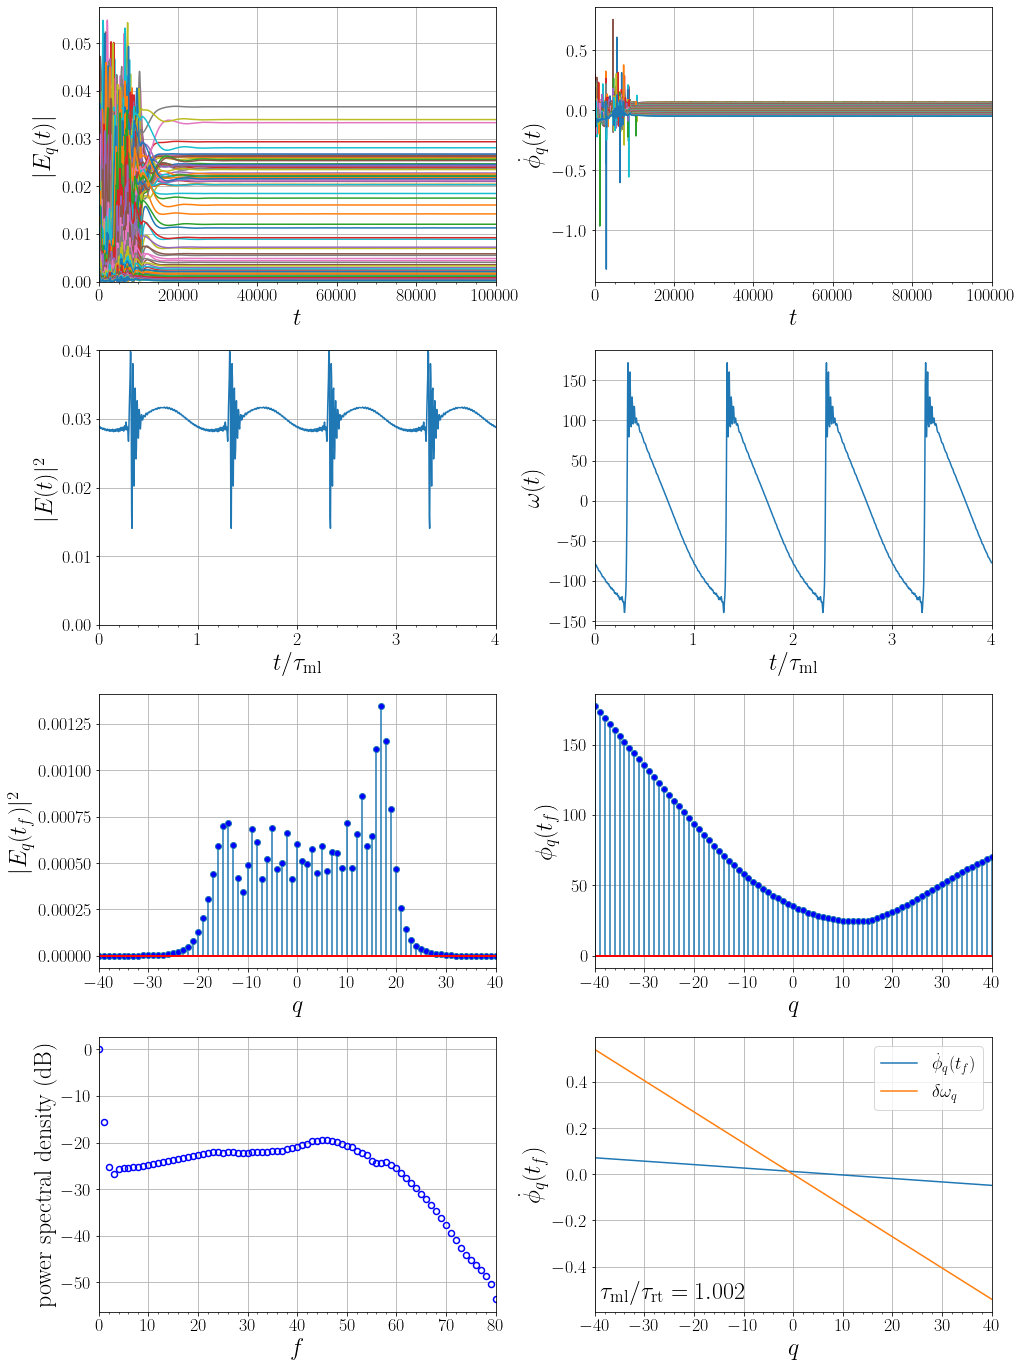

In [27]:
# Compare with the re/im cartesian algorithm.
model.integrate(t_max, method='BDF')